in this notebook I explore techniques to process CONNIE's images.

the path to the raw images is

In [1]:
%%bash
ls /share/storage2/connie/data/runs/*/*07000*

/share/storage2/connie/data/runs/043/runID_043_07000_Int-400_Exp-3600_28May19_04:12_to_28May19_05:16_p1.fits.fz


a function is defined to ease the access to the images

In [17]:
from glob import glob
def getpath(runID):
    return glob('/share/storage2/connie/data/runs/*/*_%05d_*' % runID)[0]

In [3]:
print( getpath(7000) )

/share/storage2/connie/data/runs/043/runID_043_07000_Int-400_Exp-3600_28May19_04:12_to_28May19_05:16_p1.fits.fz


a function to convert a fits file into an array with dimensions hdu × columns × lines

In [40]:
from numpy import *
import astropy.io.fits
from scipy.optimize import curve_fit

In [41]:
def gethdulist( path ):
    hdulist = astropy.io.fits.open( path )
    names, data = zip(*[ (hdu.header['ohdu'], hdu.data.T) for hdu in hdulist if not 'PrimaryHDU' in str(type(hdu)) ])
    return names, array(data)

read the runID 7001 and print its shape

In [438]:
names, data = gethdulist( getpath(7001) )
print( names )
print( data.shape )
data = flip(data, axis=-1)
reshape = insert( data.shape, 1, -1 )
reshape[2] //=2
print( reshape )
sdata = data.reshape( reshape )
print( sdata.shape )
sdata[:,1] = flip(sdata[:,1], axis=1)
sdata = sdata.astype(float)

(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)
(14, 9340, 900)
[  14   -1 4670  900]
(14, 2, 4670, 900)


load module for plotting

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({
    "image.origin": 'below',
#     "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Helvetica"]
})


a utility function to display a grid of plots

In [657]:
# def plot( plotsgrid, figsize=(16,8), ncols=1 ):
#     fig = plt.figure(figsize=figsize)
#     [ plotfunc( fig.add_subplot(len(plotsgrid), len(plotsline), i+j+1) )
#          for i, plotsline in enumerate(plotsgrid) for j, plotfunc in enumerate(plotsline) ]
#     plt.show()

def plot_list( *plot_list, figsize=(16,4), ncols=1 ):
    nrows = len(plot_list)//ncols
    fig = plt.figure(figsize=(figsize[0],figsize[1]*nrows))
    [ ( lambda ax: [ 
        func(ax) for func in (funcs if hasattr(funcs,'__iter__') else [funcs])
        ] )( fig.add_subplot(nrows, ncols, i+1) )
         for i, funcs in enumerate(plot_list) ]
    plt.show()

for func in ['bar','plot', 'set_ylabel', 'set_xlabel', 'set_ylim', 'set_xlim', 'grid', 'imshow', 'scatter', 
             'legend', 'step', 'quiver']:
    exec(f'{func} = lambda *args, **kwargs: lambda ax: ax.{func}(*args, **kwargs)')

hist = lambda *args, **kwargs: lambda ax: ax.hist(*args, **kwargs)
# histfancy = lambda x, binsize, label, digits, **kwargs: (lambda ax: ax.hist(x.flatten(), 
#                        bins=arange(x.min(),x.max(),binsize=binsize),
#                        label = f'{label}\n$\mu={round(mean(x),digits)$\n$\mu={round(std(x),digits)}$'
#                       ))
set_yscale = lambda *args, **kwargs: lambda ax: ax.set_yscale(*args, **kwargs)

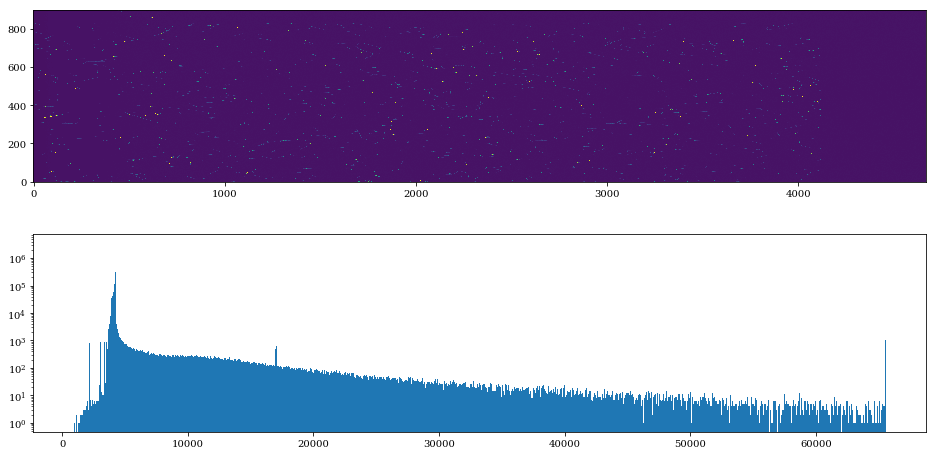

In [8]:
plot_list(
    imshow(sdata[0,0].T), 
    [ hist(sdata[0,0].flatten(), bins=1000), set_yscale('log') ]
)

function to plot the image and histograms on both sides

In [632]:
sigma = lambda d, nsigma=1: nanmean(d) + nsigma*nanstd(d)
image = lambda d, nsigma=1: { 'X':d.T, 'vmin':sigma(d,-nsigma), 'vmax':sigma(d, nsigma) }

def plot_profile( data, binsize=100, sigma=.1 ):
    plot_list(
        imshow(**image( data, sigma)), 
        [ 
            (lambda x: hist(x, 
                            bins = arange(x.min(),x.max(),binsize),
                           label = f'$\mu={round(mean(x),3)}$\n$\sigma={round(std(x),3)}$')
            )(data.flatten()), 
            set_yscale('log'),
            legend()
        ],
    )

In [ ]:
plot_profile(sdata[0,0])

the distribution shows a short tail to the right of the highest peak and aanother very long one to the left.

let us take a look at the idle amplifier to get a better picture of this structure without the measured charges.

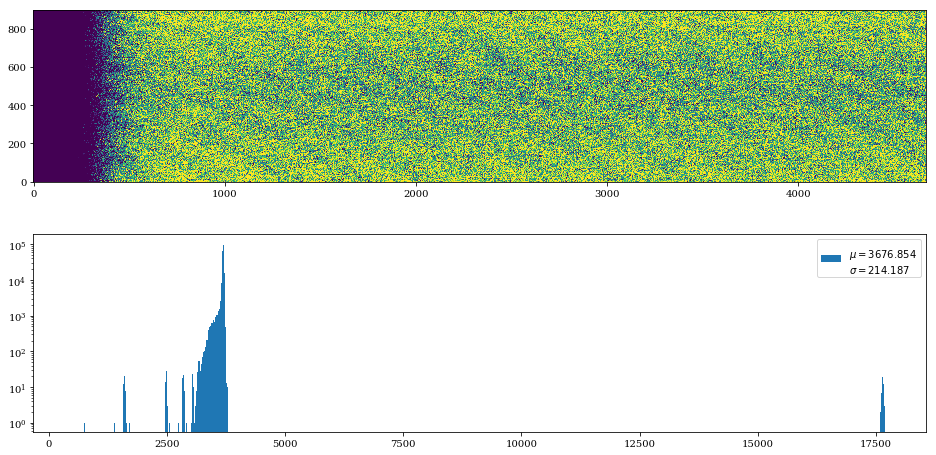

In [11]:
plot_profile(sdata[0,1],binsize=1)

there are distinct peaks below the highest peak and a sole peak to the right.

let us investigate the right-side tail

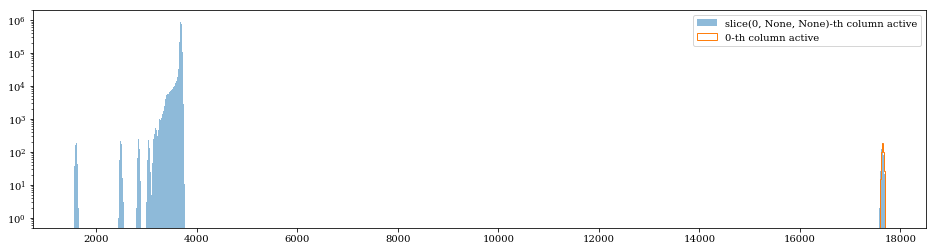

In [12]:
plot_list(
    [ (lambda x: hist(
        x, 
        bins=arange(x.min(),x.max(),10), 
        label=f'{column}-th column active', 
        alpha = 1 if not type(column) == slice else .5,
        histtype = 'bar' if type(column) == slice else 'step' )
      )( sdata[0,1,column,1:].flatten() ) for column in [slice(0,None),0] 
    ] + [set_yscale('log'), legend()]
)

the sole right peak is clearly identified as the first column of the data

about the other peaks to the left 

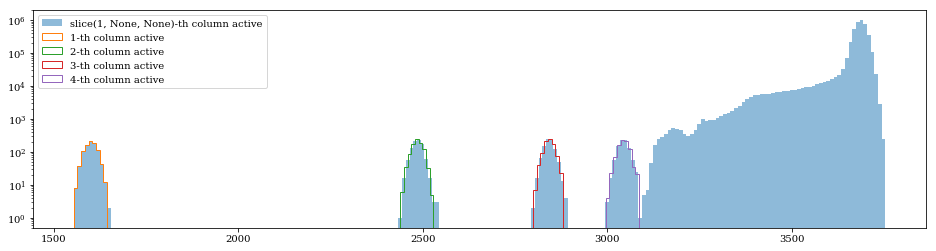

In [13]:
plot_list(
    [ (lambda x: hist(
        x, 
        bins=arange(x.min(),x.max(),10), 
        label=f'{column}-th column active', 
        alpha = 1 if not type(column) == slice else .5,
        histtype = 'bar' if type(column) == slice else 'step' )
      )( sdata[0,1,column,1:].flatten() ) for column in [slice(1,None),1,2,3,4] 
    ] + [set_yscale('log'), legend()]
)

the peaks to the left are ordered from the 2nd column onwards

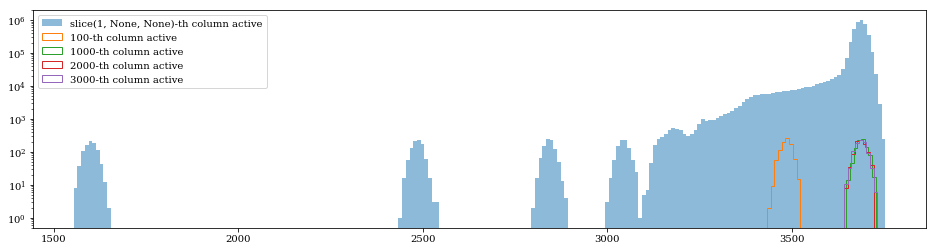

In [14]:
plot_list(
    [ (lambda x: hist(
        x, 
        bins=arange(x.min(),x.max(),10), 
        label=f'{column}-th column active', 
        alpha = 1 if not type(column) == slice else .5,
        histtype = 'bar' if type(column) == slice else 'step' )
      )( sdata[0,1,column,1:].flatten() ) for column in [slice(1,None),100,1000,2000,3000] 
    ] + [set_yscale('log'), legend()]
)

the columns stabilize slowly

let us take a look on the distribution of the lines

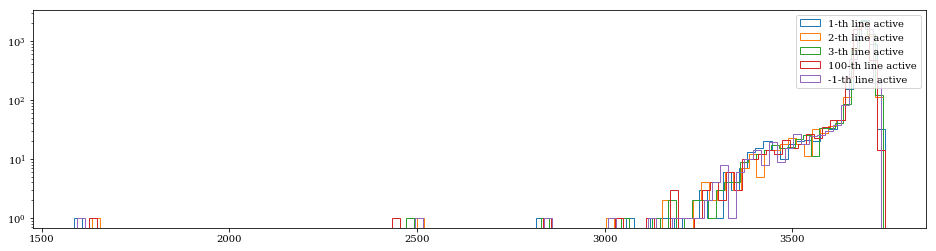

In [15]:
plot_list(
    [ hist(sdata[0,1,1:,line], bins=100, label=f'{line}-th line active', histtype='step')
     for line in [1,2,3,100,-1]
    ] + [set_yscale('log'), legend()],
)

we excluded the first column and see the structure of the remaining columns in the left

let us see the distribution keeping the columns from 1000 to above and compare with the distributions in the other dimension

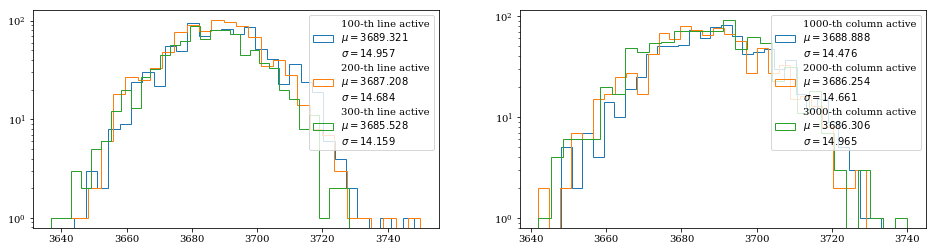

In [16]:
plot_list(
    [ (lambda x: hist(x, 
           bins=30, 
           label=f'{line}-th line active\n$\mu={round(mean(x),3)}$\n$\sigma={round(std(x),3)}$', 
           histtype='step'))(sdata[0,1,1000:1900,line])
     for line in [100, 200, 300]
    ] + [set_yscale('log'), legend()],
    [ (lambda x: hist(x,
           bins=30, 
           label=f'{column}-th column active\n$\mu={round(mean(x),3)}$\n$\sigma={round(std(x),3)}$', 
           histtype='step'))(sdata[0,1,column,:])
     for column in [1000,2000,3000]
    ] + [set_yscale('log'), legend()],
    ncols=2
)

let us try to fix the columns first by subtracting their means

# correct columns

In [629]:
s2data = copy(sdata[:,:,:,1:])
s2data[:,1] = sdata[:,1,:,1:] - mean(sdata[:,1,:,1:], axis=-1, keepdims=True)
s2data.shape

(14, 2, 4670, 899)

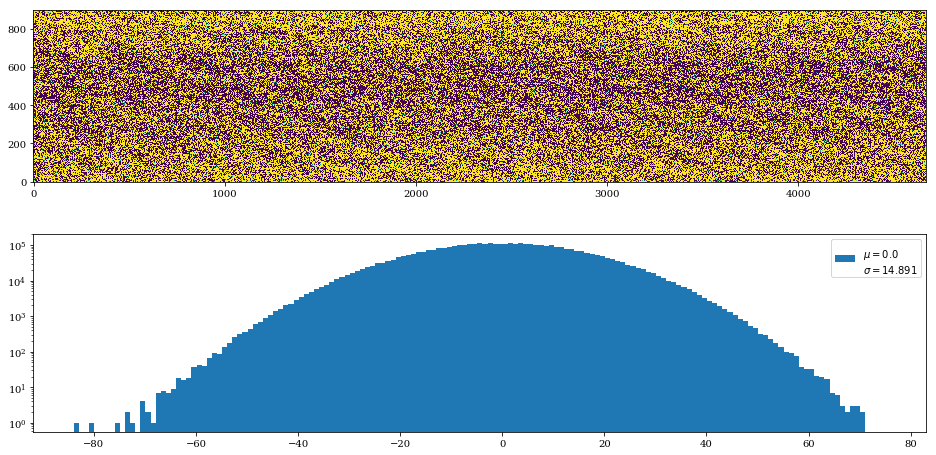

In [18]:
plot_profile(s2data[0,1],binsize=1)

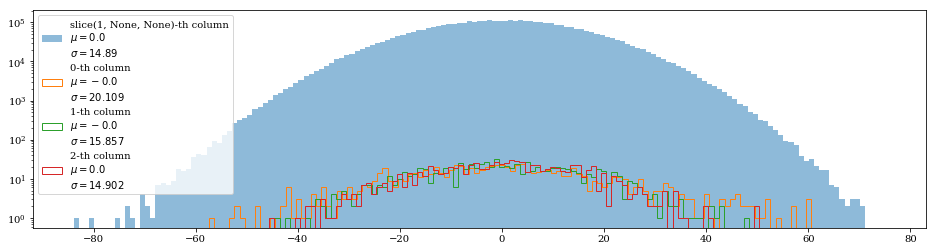

In [19]:
plot_list(
    [ (lambda x: hist(
        x, 
        bins=arange(x.min(),x.max(),1), 
        label=f'{column}-th column\n$\mu={round(mean(x),3)}$\n$\sigma={round(std(x),3)}$', 
        alpha = 1 if not type(column) == slice else .5,
        histtype = 'bar' if type(column) == slice else 'step' )
      )( s2data[0,1,column].flatten() ) for column in [slice(1,None),0,1,2] 
    ] + [set_yscale('log'), legend()]
)

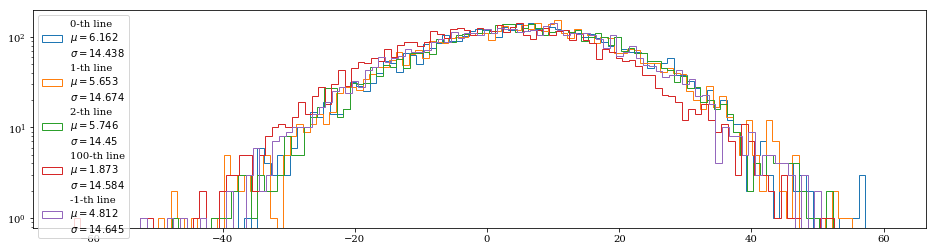

In [20]:
plot_list(
    [ (lambda x: hist(x, 
                      bins=arange(x.min(),x.max(),1), 
                      label=f'{line}-th line\n$\mu={round(mean(x),3)}$\n$\sigma={round(std(x),3)}$', 
                      histtype='step')
      )(s2data[0,1,1:,line])
     for line in [0,1,2,100,-1]
    ] + [set_yscale('log'), legend()],
)

all the lines align and we confirm that the first line is spoiled and cannot be corrected with this method

let us go forth and correct for the lines now and remove the first line

In [630]:
s3data = copy(s2data)
s3data[:,1] = s2data[:,1] - mean(s2data[:,1], axis=-2, keepdims=True)

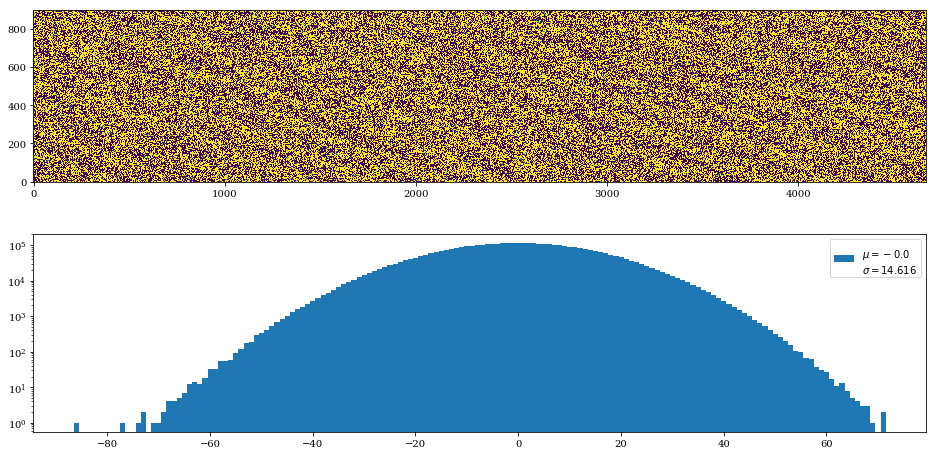

In [633]:
plot_profile(s3data[0,1], binsize=1)

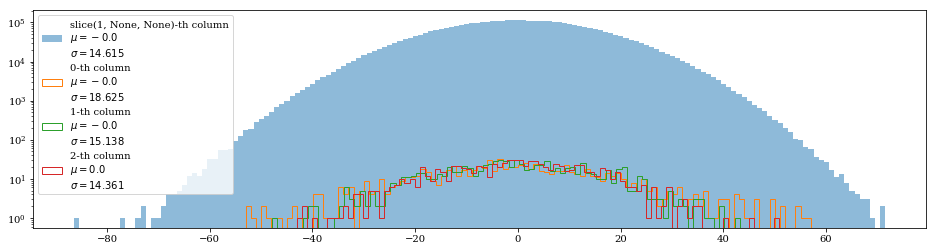

In [635]:
plot_list(
    [ (lambda x: hist(
        x, 
        bins=arange(x.min(),x.max(),1), 
        label=f'{column}-th column\n$\mu={round(mean(x),3)}$\n$\sigma={round(std(x),3)}$', 
        alpha = 1 if not type(column) == slice else .5,
        histtype = 'bar' if type(column) == slice else 'step' )
      )( s3data[0,1,column].flatten() ) for column in [slice(1,None),0,1,2] 
    ] + [set_yscale('log'), legend()]
)

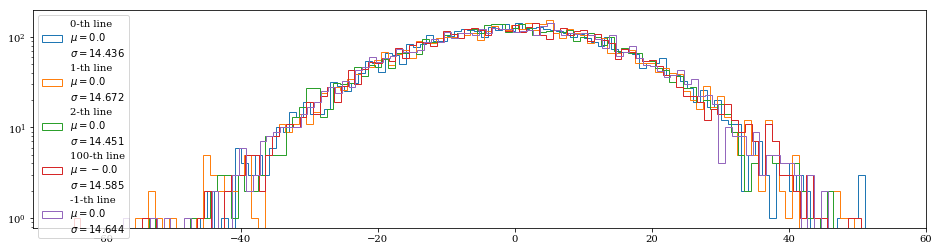

In [636]:
plot_list(
    [ (lambda x: hist(x, 
                      bins=arange(x.min(),x.max(),1), 
                      label=f'{line}-th line\n$\mu={round(mean(x),3)}$\n$\sigma={round(std(x),3)}$', 
                      histtype='step')
      )(s3data[0,1,:,line])
     for line in [0,1,2,100,-1]
    ] + [set_yscale('log'), legend()],
)

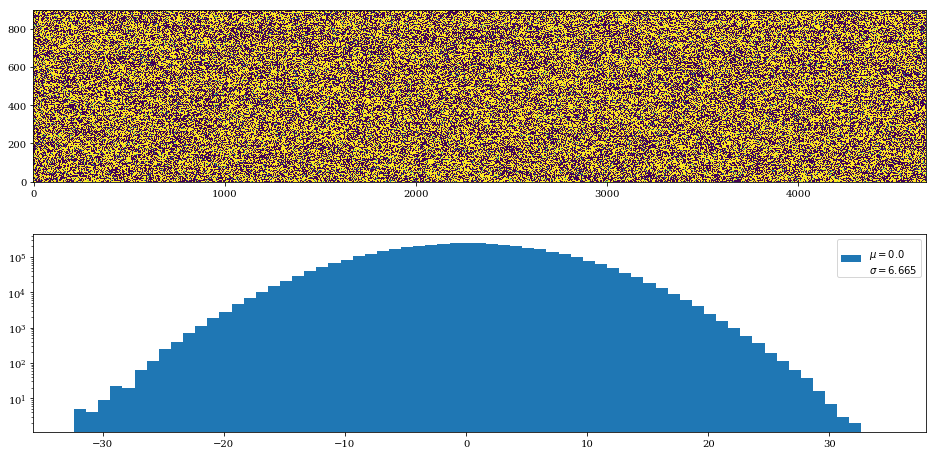

In [637]:
plot_profile(mean(s3data[:,1],axis=0), binsize=1)

(4670, 899)


/opt/versatushpc/softwares/anaconda3/5.0-intel-2018.0/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


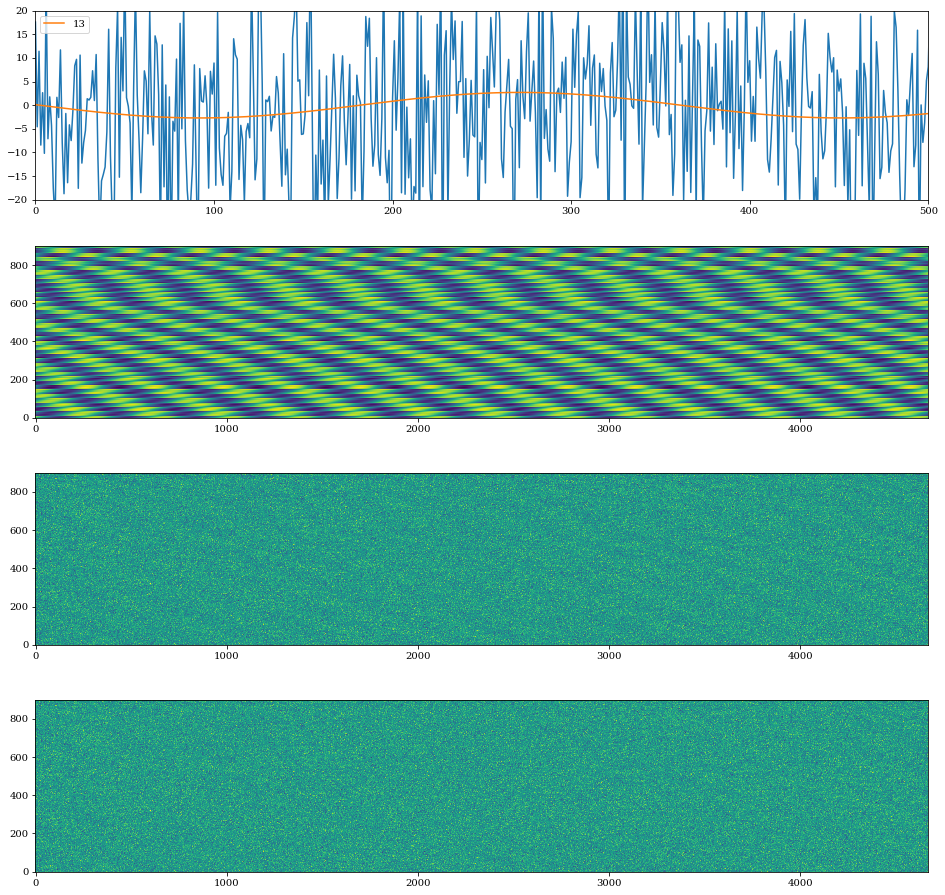

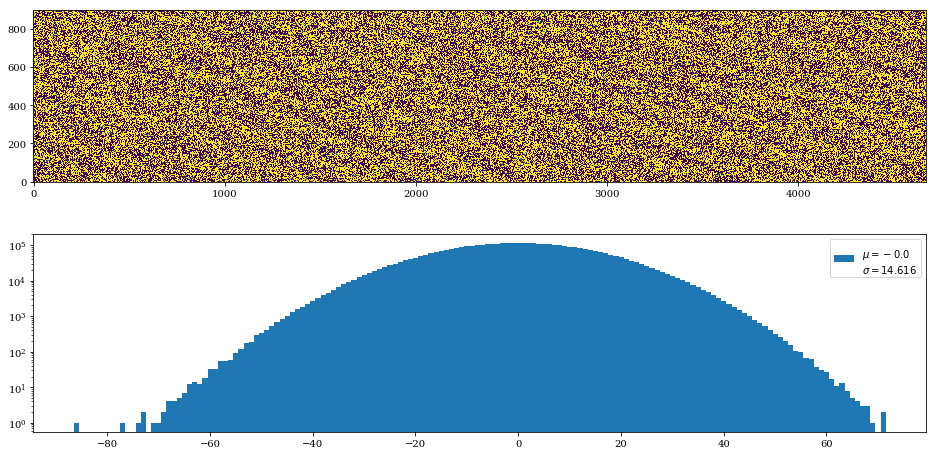

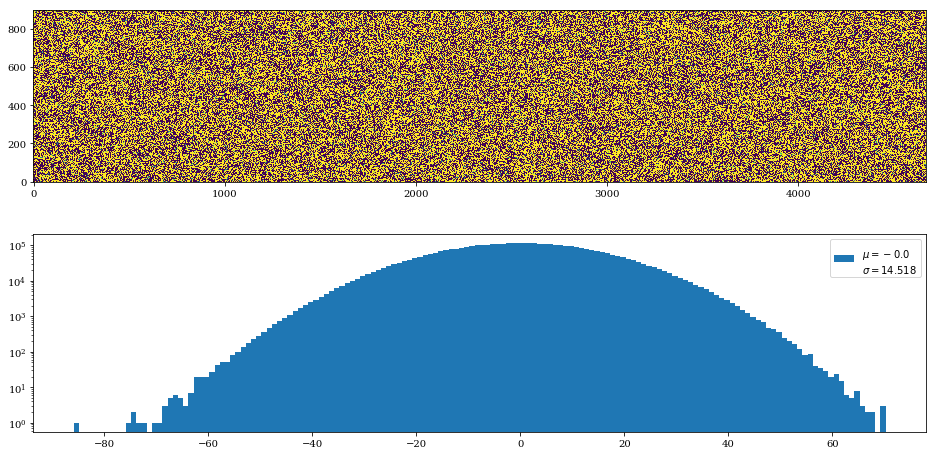

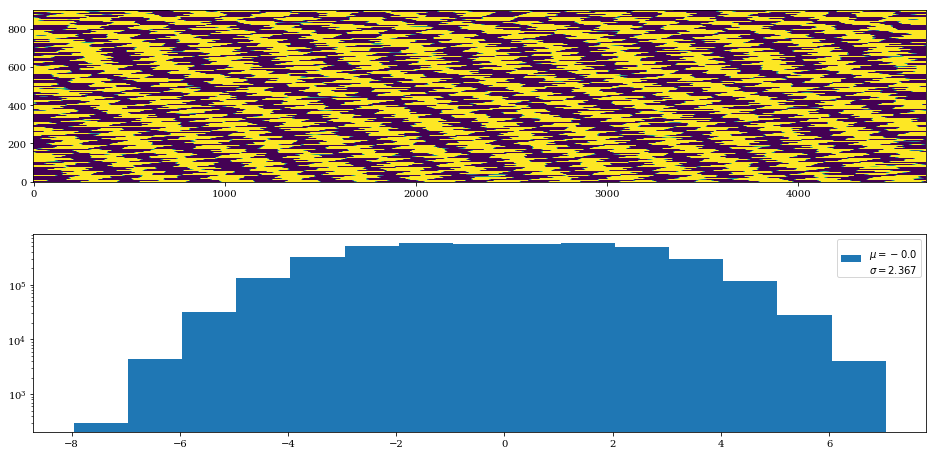

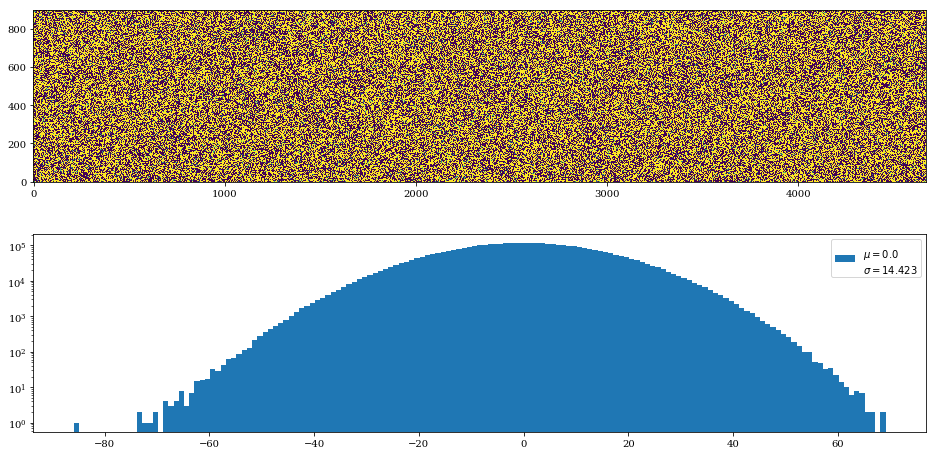

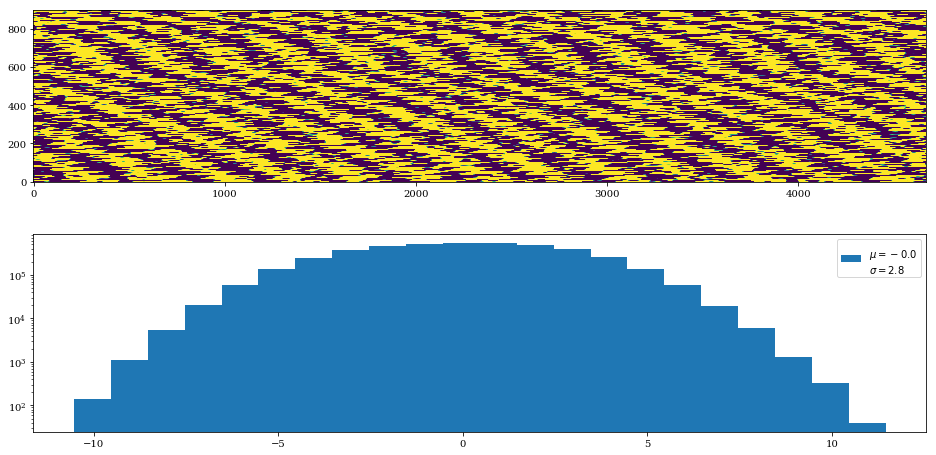

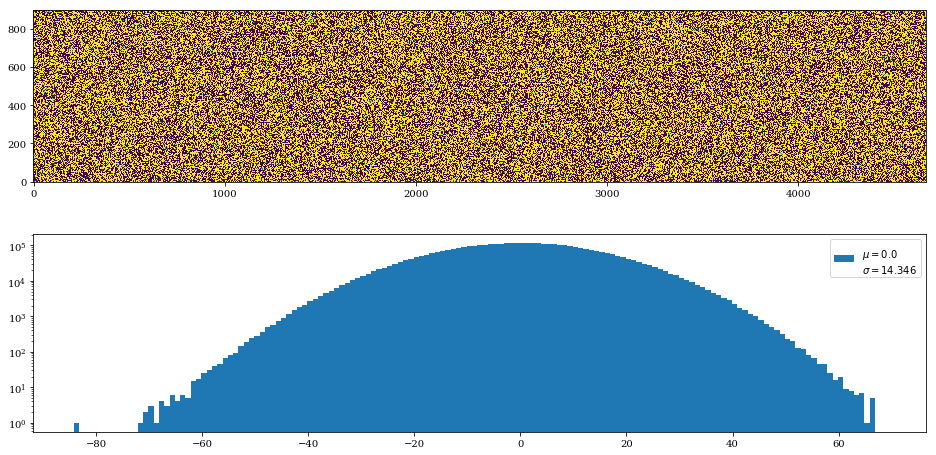

[497 498 888] [1.56385531 1.52112335 1.38533937]


In [878]:
fourier = lambda x, n: 2*mean(
    x*exp(1j*arange(x.size).astype(float)/x.size*2*pi*n),
    axis=0
)
def fourierComponent(x, n, verbose=False):
    coeff = fourier(x, n)
    if verbose: print(n, abs(coeff) )
    return coeff*exp(-1j*arange(x.size).astype(float)/x.size*2*pi*n)

def printCoeffs( _ ):
    coeffs = [abs(fourier(_, n)) for n in range(1000) ]
    Max = max(coeffs)
    sortind = argsort(coeffs)[::-1]
    print( 
        sortind[:3], array(coeffs)[sortind[:3]]
    ) 
# print( 4000/13. )
# for n in range(5):
#     printCoeffs( s3data[n,1,:,10] )
#     printCoeffs( s3data[n,1,:,100] )
#     printCoeffs( s3data[n,1,:,500] )
#     printCoeffs( s3data[n,1,:,800] )

mask = array([ fourierComponent(s3data[0,1,:,n], 13).real for n in range(s3data[0,1].shape[1]) ]).T

print( mask.shape )
plot_list(
    [
        plot(s3data[0,1,:,10]),
    ]+[     
        plot(fourierComponent(s3data[0,1,:,10], n), label=f'{n}') for n in [13]
    ]+[
        legend(),
        set_ylim(-20,20),
        set_xlim(0,500)
    ],
    [
        imshow( mask.T )
    ],
    [
        imshow( s3data[0,1].T )
    ],
    [
        imshow( (s3data[0,1]- mask).T )
    ]
)
plot_profile(s3data[0,1], binsize=1 )
masksub = s3data[0,1]- mask
plot_profile(s3data[0,1] - mask, binsize=1 )
mask2 = array([ 
    sum( [ fourierComponent(s3data[0,1,:,n], m).real for m in range(20)], axis=0 )
    for n in range(s3data[0,1].shape[1])
]).T
plot_profile( mask2, binsize=1 )
plot_profile(s3data[0,1] - mask2, binsize=1 )

mask3 = array([ 
    sum( [ fourierComponent(s3data[0,1,:,n], m).real for m in range(50)], axis=0 )
    for n in range(s3data[0,1].shape[1])
]).T
plot_profile( mask3, binsize=1 )
plot_profile(s3data[0,1] - mask3, binsize=1 )

printCoeffs( masksub[:,400] )

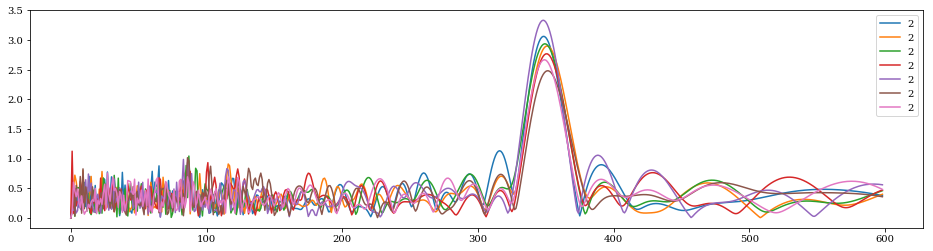

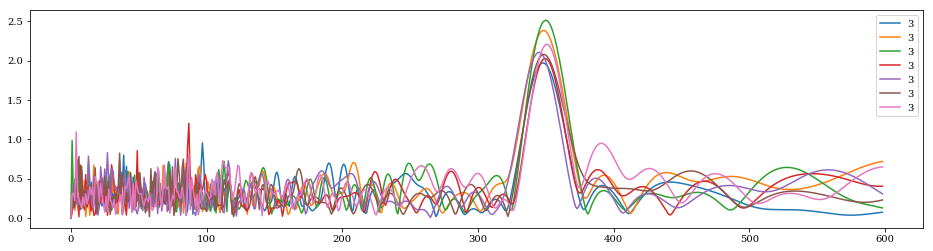

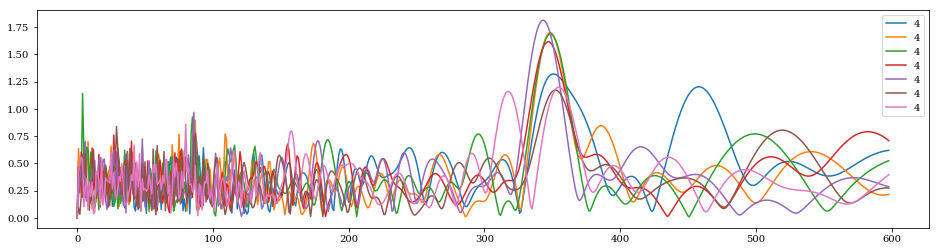

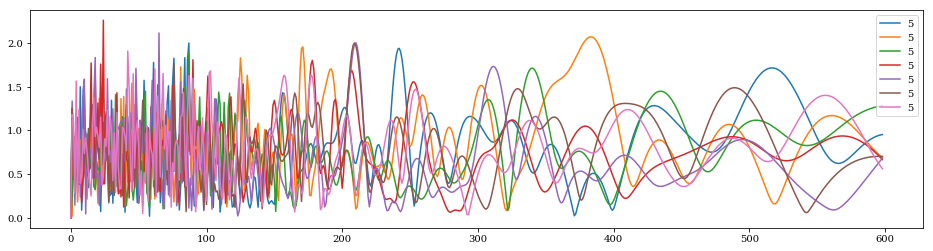

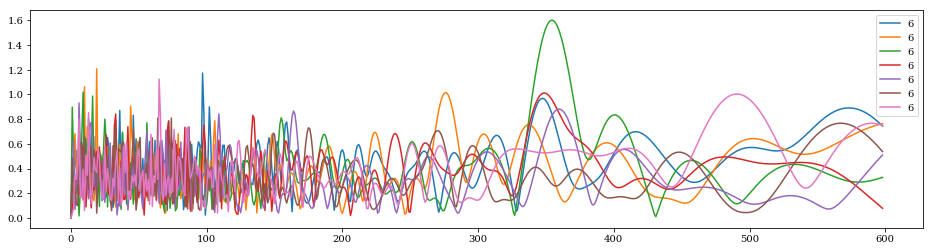

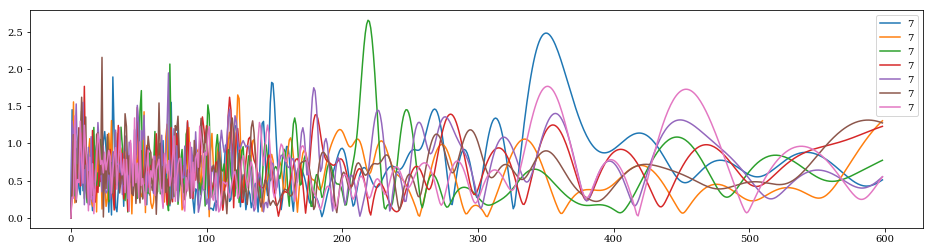

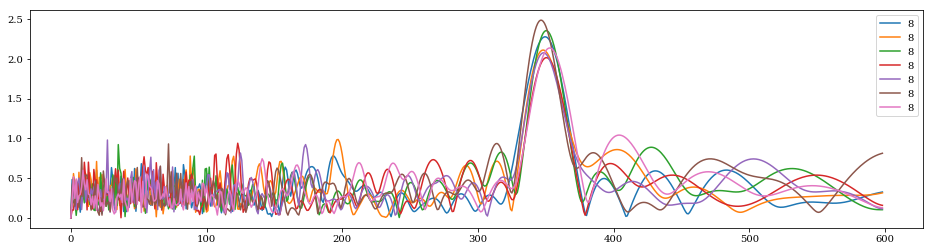

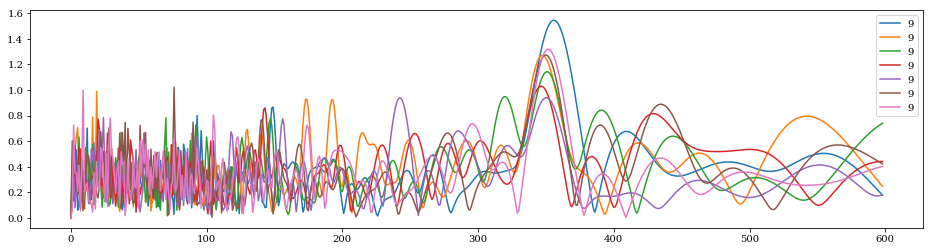

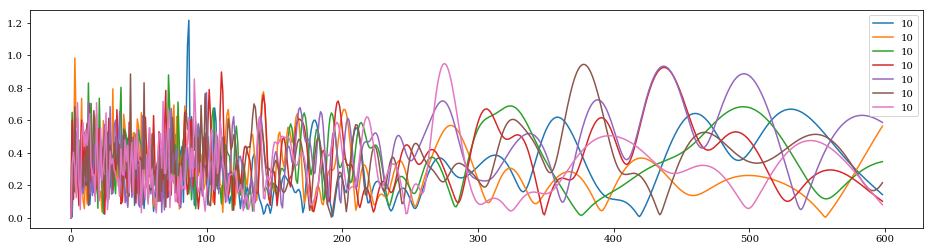

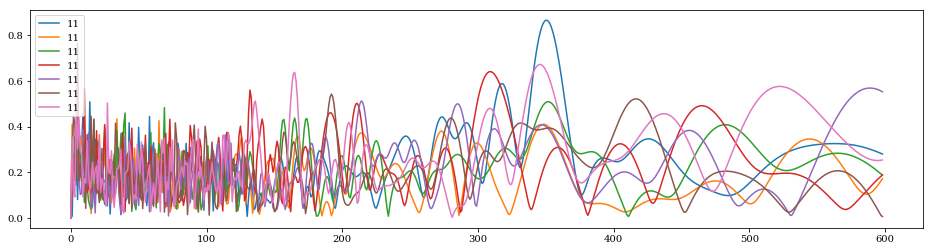

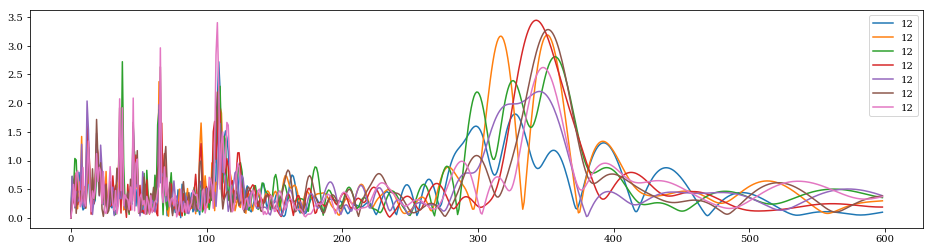

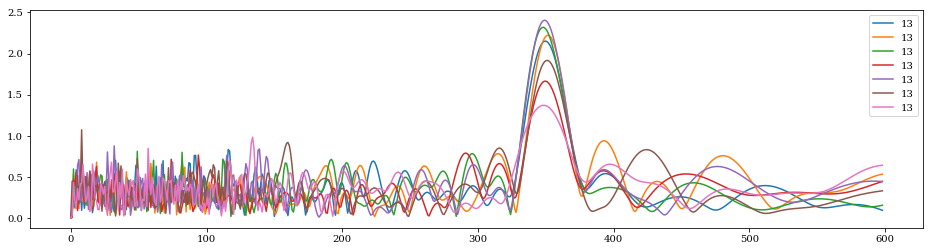

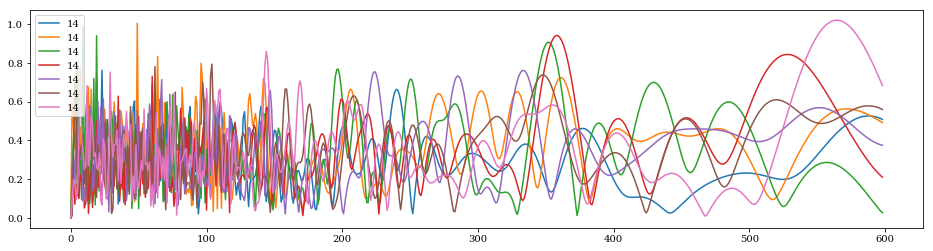

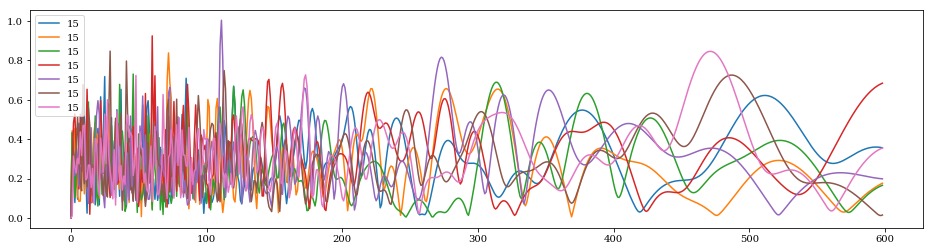

In [916]:
fourier = lambda x, L: 2*mean(
    x*exp(1j*arange(x.size).astype(float)*2*pi/L),
    axis=0
)
def fourierComponent(x, L, verbose=False):
    coeff = fourier(x, L)
    if verbose: print(n, abs(coeff), angle(coeff) )
    return coeff*exp(-1j*arange(x.size).astype(float)*2*pi/L)

def printCoeffs( _ ):
    coeffs = [abs(fourier(_, n)) for n in range(50,int(_.size/3)) ]
    Max = max(coeffs)
    sortind = argsort(coeffs)[::-1]
    print( 
        sortind[:3], array(coeffs)[sortind[:3]]
    ) 

for k in range(14):
    plot_list(
        [     
            plot( 
                [ abs(fourier(s3data[k,1,:,m], n)) for n in range(1, 600) ], 
                label=f'{k+2}'
            )
            for m in [50,100,150, 300, 500, 800, 890]
        ]+[
            legend(),
        ]
    )


(4670, 899)


/opt/versatushpc/softwares/anaconda3/5.0-intel-2018.0/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


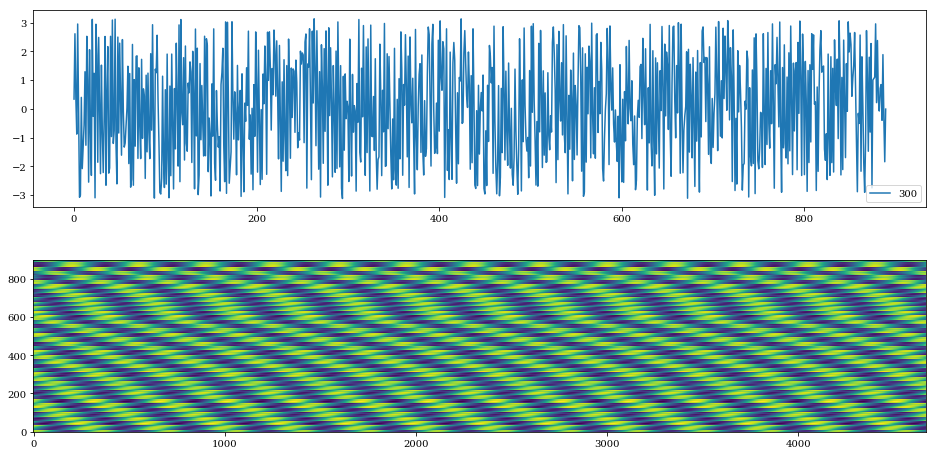

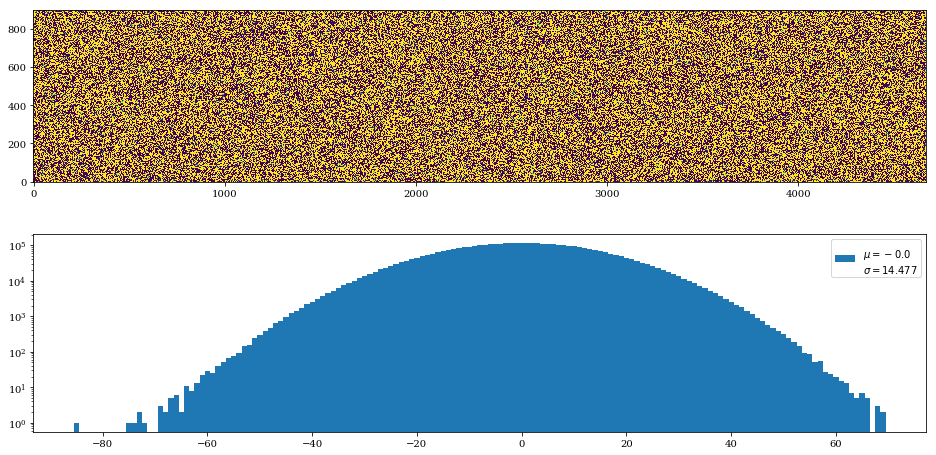

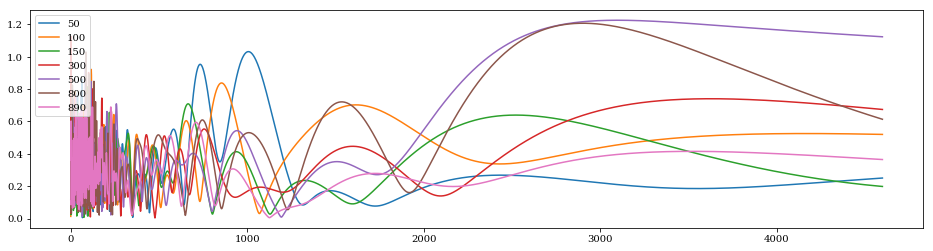

In [922]:
mask = array(
    [ fourierComponent(s3data[0,1,:,m], 350).real for m in range(s3data[0,1].shape[1]) ]
).T
print( mask.shape )
plot_list(
    [     
        plot( 
            [ angle(fourier(s3data[0,1,:,m], n)) for m in range(890) ],
            label=f'{n}'
        )
        for n in [300]
    ]+[
        legend(),
    ],
    [     
        imshow( 
            mask.T
        ),
        legend(),
    ],
)
masked = s3data[0,1] - mask
plot_profile( masked, binsize=1 )
plot_list(
    [     
        plot( 
            [ abs(fourier(masked[:,m], n)) for n in range(1, 4600) ], 
            label=f'{m}'
        )
        for m in [50,100,150, 300, 500, 800, 890]
    ]+[
        legend(),
    ]
)


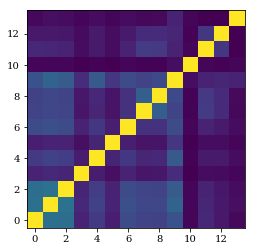

In [638]:
coeffs = (lambda x: corrcoef( x ) )(s3data[:,1].reshape(s3data.shape[0],-1))
plot_list( [ imshow( coeffs ) ] )

In [639]:
sum( s3data[0,1].flatten() * s3data[1,1].flatten() )/sqrt(
    sum(s3data[0,1].flatten() * s3data[0,1].flatten())*sum(s3data[1,1].flatten() * s3data[1,1].flatten()))

0.37257255166563497

In [808]:
s4data = copy(s3data)
s4data[:,1] = 2*s3data[:,1] - einsum('ij...,i...->j...', coeffs, s3data[:,1] )
s4data[:,1].shape

(14, 4670, 899)

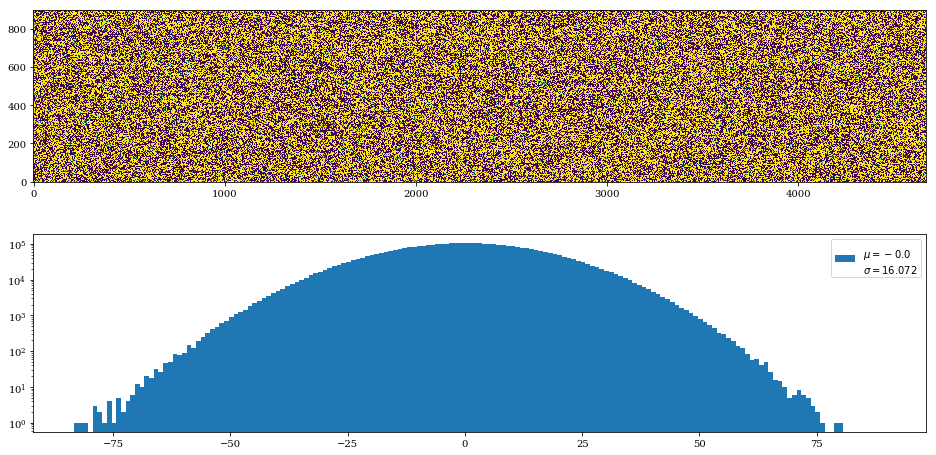

In [809]:
plot_profile(s4data[0,1], binsize=1)

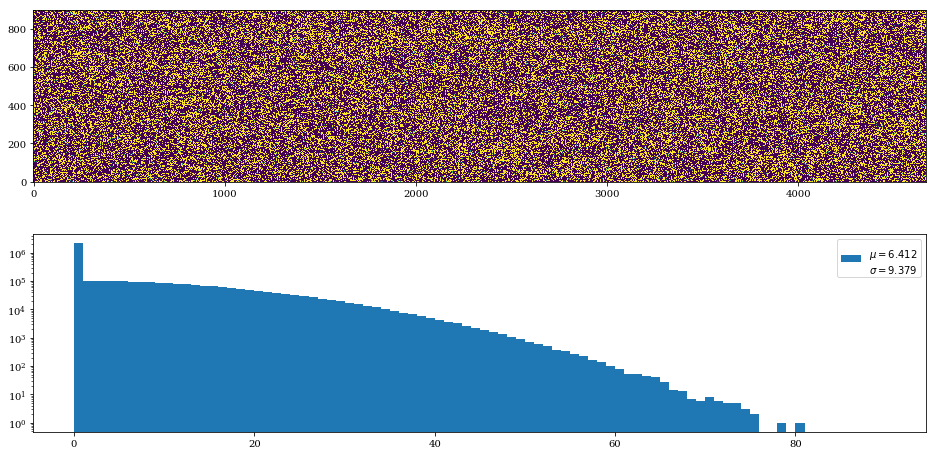

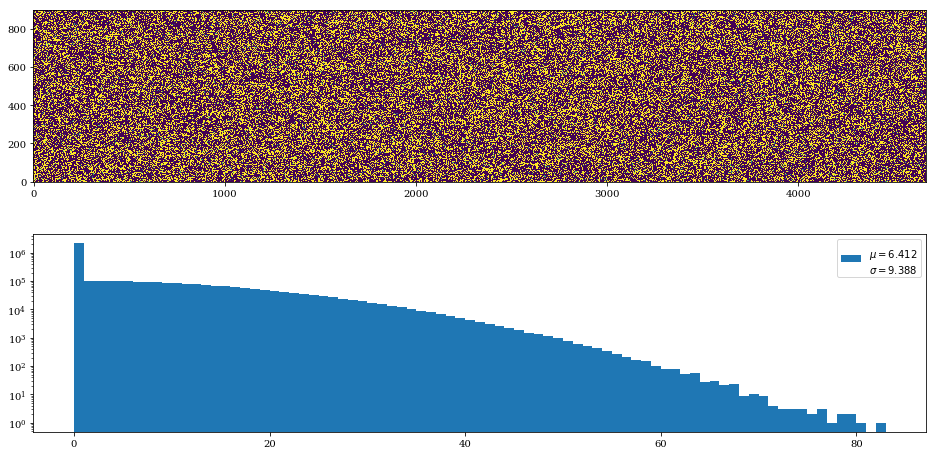

In [810]:
pos_s4data = 1*s4data[0,1]
neg_s4data = 1*s4data[0,1]
pos_s4data[pos_s4data<=0] = 0
neg_s4data[neg_s4data>=0] = 0
neg_s4data *= -1
plot_profile(pos_s4data, binsize=1)
plot_profile(neg_s4data, binsize=1)

In [811]:
def gradient( im ):
    xN, yN = im.shape
    N = 8
    units = [ round(exp(1j*n*2*pi/N)) for n in range(N)]
    sl = []
    for u in units:
        dx = int(round(u.real))
        dy = int(round(u.imag))
        sx = slice( 1+dx, xN-2+1+dx)
        sy = slice( 1+dy, yN-2+1+dy)
        sl.append( (sx, sy) )
    ret2 = sum( [ u*im[s]/abs(u)/2 for u, s in zip(array(units), sl) ], axis=0 )
    return ret2, im[1:-1,1:-1]

grad4, im_new4 = gradient( s4data[0,1] )

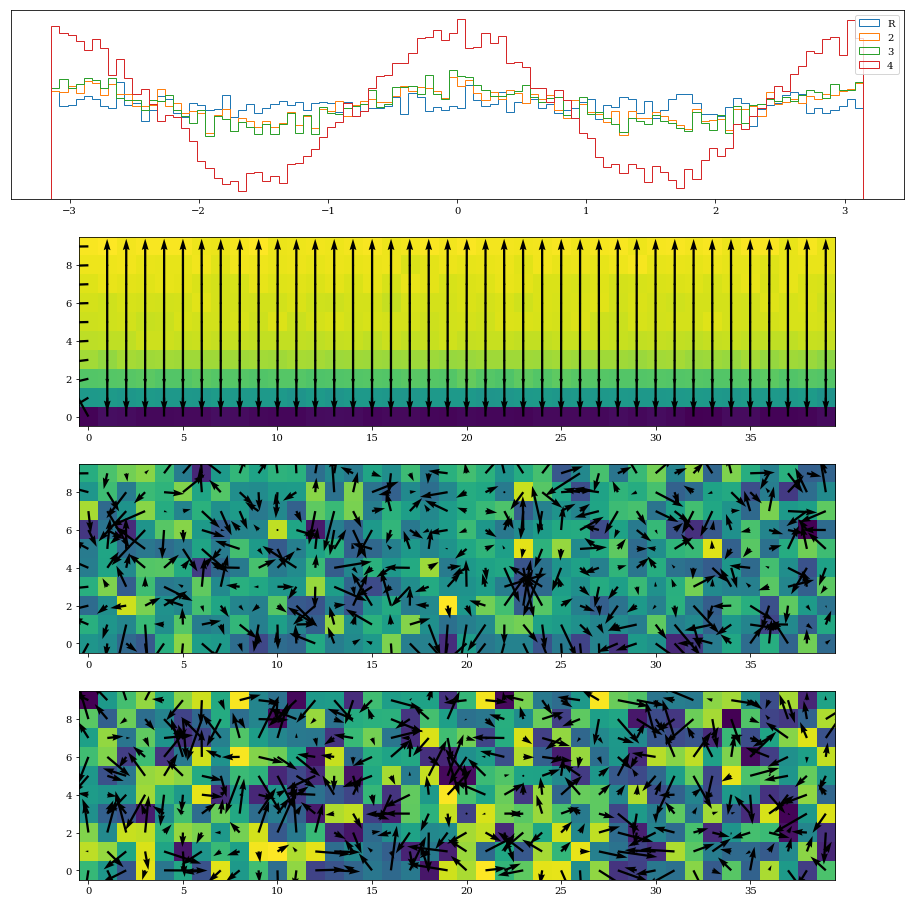

In [812]:
from numpy.random import rand
randImage = rand( *s4data[0,1].shape )
grad, im_new = gradient( sdata[0,1] )
grad2, im_new2 = gradient( s2data[0,1] )
grad3, im_new3 = gradient( s3data[0,1] )
gradR, im_newR = gradient( randImage )

plot_list(
    [
        hist( angle(gradR).flatten(), weights=abs(gradR).flatten(), 
             bins=100, histtype='step', label='R', normed=True ),
        hist( angle(grad2).flatten(), weights=abs(grad2).flatten(), 
             bins=100, histtype='step', label='2', normed=True ),
        hist( angle(grad3).flatten(), weights=abs(grad3).flatten(), 
             bins=100, histtype='step', label='3', normed=True ),
        hist( angle(grad4).flatten(), weights=abs(grad4).flatten(), 
             bins=100, histtype='step', label='4', normed=True ),
        set_yscale('log'),
        legend()
    ],
    [
        imshow(im_new[:10,:40]),
        quiver(-grad.imag[:10,:40], -grad.real[:10,:40] )
    ],
    [
        imshow(im_new4[:10,:40]),
        quiver(-grad4.imag[:10,:40], -grad4.real[:10,:40] )
    ],
    [
        imshow(im_newR[:10,:40]),
        quiver(-gradR.imag[:10,:40], -gradR.real[:10,:40] )
    ],
)


/opt/versatushpc/softwares/anaconda3/5.0-intel-2018.0/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/opt/versatushpc/softwares/anaconda3/5.0-intel-2018.0/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


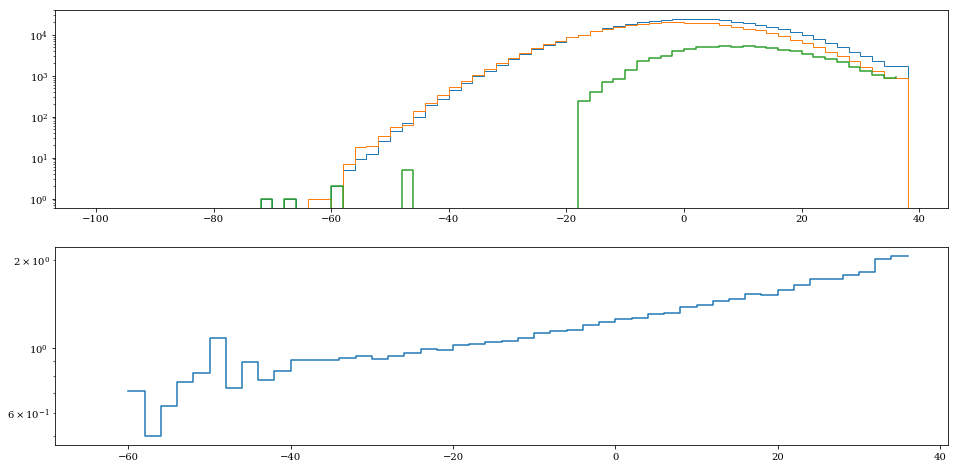

In [616]:
active = (sdata[0,0,1000:1500,10:] - median( sdata[0,0,-400:,10], axis=0, keepdims=True ) ).flatten()
overscan = (sdata[0,0,-400:,10:] - median( sdata[0,0,-400:,10], axis=0, keepdims=True ) ).flatten()

Ebins = arange(-100, 40, 2) 
plot_list(
#     [ hist(sdata[0,0].flatten(), bins=1000), set_yscale('log'), set_ylim() ],
    [ 
        hist(
            active, 
            bins=Ebins,
            histtype='step'
        ), 
        hist(
            overscan, 
            bins=Ebins,
            histtype='step'
        ),
        step(
            Ebins[:-1],
            histogram(active, bins=Ebins)[0] - histogram(overscan, bins=Ebins)[0],
            where='post'
        ), 
        set_yscale('log') 
    ],
    [
        step(
            Ebins[:-1],
            histogram(active, bins=Ebins)[0]/histogram(overscan, bins=Ebins)[0],
            where='pre'
        ), 
        set_yscale('log') 
    ],
)

In [617]:
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.stats import norm, poisson

def fourier( func, a, b, **kwargs ):
    return vectorize( 
        lambda omega: 
        quad( lambda E: (func(E)*exp(1j * omega * E)).real, a, b, **kwargs )[0]/sqrt(2*pi)
        + 1j* quad( lambda E: (func(E)*exp(1j * omega * E)).imag, a, b, **kwargs )[0]/sqrt(2*pi)
    )

_Ebins = arange(-100, 101, 1)
pdfActive = histogram(
    active,
    bins = _Ebins
)[0]
pdfOverscan = histogram(
    overscan,
    bins = _Ebins
)[0]

14.138768569583387 -1.1677219101123595

/opt/versatushpc/softwares/anaconda3/5.0-intel-2018.0/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


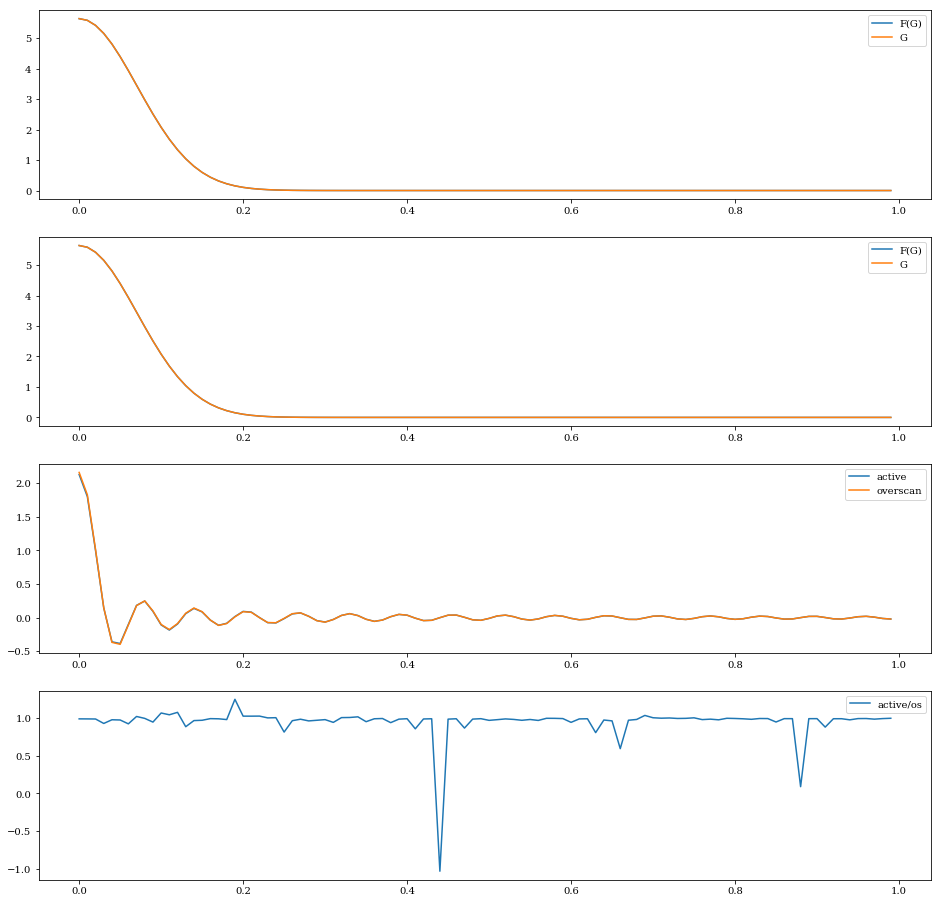

In [624]:
_sigma = std( overscan )
_mu = mean( overscan )
print( _sigma, _mu ) 
_E = .5*(_Ebins[1:] + _Ebins[:-1])

_omega = arange(0, 1., .01)

pdfOverscanFunc = interp1d( _E, pdfOverscan.astype(float)/sum(pdfOverscan) )
pdfActiveFunc = interp1d( _E, pdfActive.astype(float)/sum(pdfActive) )

fourier_pdfActive = fourier( lambda E: pdfActiveFunc(E/_sigma), -100, 100, epsrel=1e-2, limit=100 )(_omega)
fourier_pdfOverscan = fourier( lambda E: pdfOverscanFunc(E/_sigma), -100, 100, epsrel=1e-2, limit=100 )(_omega)

plot_list(
    [
        plot( 
            _omega, 
            fourier( 
                lambda E: norm.pdf(E/_sigma), 
                -100, 100, epsrel=1e-2, limit=50 
            )(_omega).real,
            label = 'F(G)'
        ),
        plot( 
            _omega, 
            _sigma*norm.pdf( _sigma*_omega ).real, 
            label = 'G'
        ), #*exp(1j*_mu*_omega) ),
#         set_yscale('log'),
        legend()
    ],
    [
        plot( 
            _omega, 
            fourier( 
                lambda E: norm.pdf(E/_sigma), 
                -100, 100, epsrel=1e-2, limit=50 
            )(_omega).real,
            label = 'F(G)'
        ),
        plot( 
            _omega, 
            _sigma*norm.pdf( _sigma*_omega ).real, 
            label = 'G'
        ), #*exp(1j*_mu*_omega) ),
#         set_yscale('log'),
        legend()
    ],
    [
        plot( 
            _omega, 
            fourier_pdfActive.real, 
            label='active' 
        ),
        plot( 
            _omega, 
            fourier_pdfOverscan.real,
            label='overscan'
        ),
#         set_yscale('log'),
        legend()
    ],
    [
        plot( 
            _omega, 
            ( fourier_pdfActive/fourier_pdfOverscan ).real, 
            label='active/os' 
        ),
#         set_yscale('log'),
        legend()
    ]
)

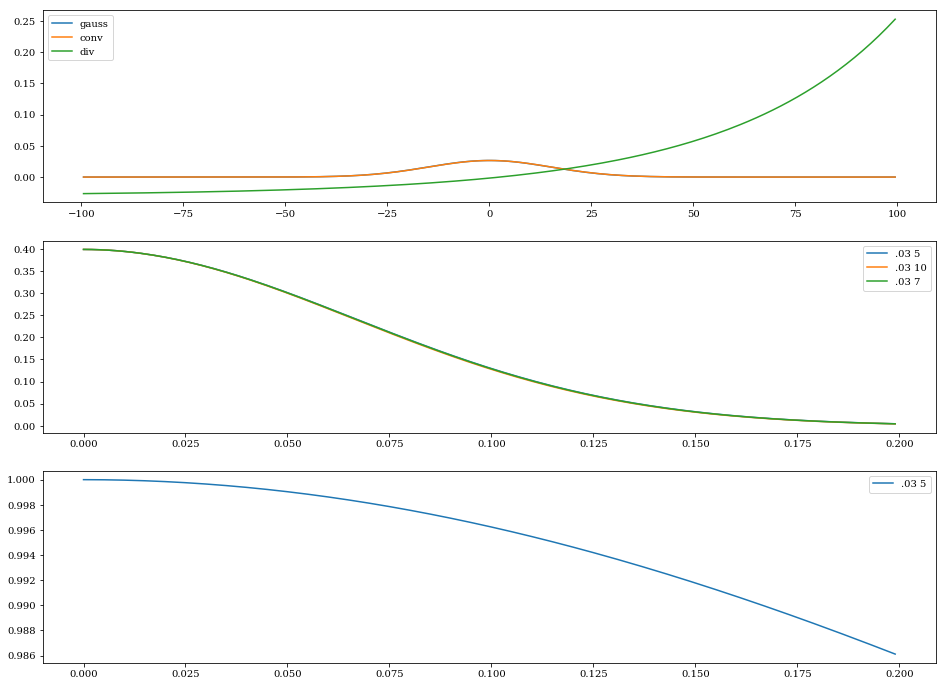

In [625]:
gain = 5
lamb = 0.1
sigma = 15
conv = lambda E, lamb, gain, sigma, nMax=10: sum( 
    [ 
        p*norm.pdf( E, loc = gain*q, scale=sigma ) 
        for q, p in enumerate( poisson.pmf( arange(nMax), mu=lamb ) )
    ],
    axis=0
)

_omega = arange(0, .2, .001)
fourier_norm = fourier( 
    lambda E: norm.pdf(E, scale=sigma), -100, 100, epsrel=1e-2, limit=100 
)
fourier_conv = lambda lamb, gain, sigma: fourier( 
    lambda E: conv(E, lamb, gain, sigma), -100, 100, epsrel=1e-2, limit=100 
)

plot_list(
    [
        plot( _E, norm.pdf(_E,scale=sigma), label='gauss' ),
#         plot( _E, conv(_E, .5, 5, 15), label='conv' ),
#         plot( _E, conv(_E, .2, 7, 15), label='conv' ),
#         plot( _E, conv(_E, .1, 7, 15), label='conv' ),
        plot( _E, conv(_E, .03, 5, 15), label='conv' ),
        plot( _E, conv(_E, .03, 5, 15)/norm.pdf(_E,scale=sigma) -1, label='div' ),
        legend(),
#         set_xlim(-25, 25),
#         set_yscale('log'),
    ],
    [
        plot( _omega, fourier_norm(_omega).real, label='.03 5' ),
        plot( _omega, (fourier_conv(0.03, 10, 15)(_omega)).real, label='.03 10' ),
        plot( _omega, (fourier_conv(0.02, 7, 15)(_omega)).real, label='.03 7' ),
        legend(),
#         set_yscale('log'),
    ],
    [
        plot( _omega, (fourier_conv(0.03, 5, 15)(_omega)/fourier_norm(_omega)).real, label='.03 5' ),
#         plot( _omega, (fourier_conv(0.03, 10)).real, label='.03 10' ),
#         plot( _omega, (fourier_conv(0.02, 7)).real, label='.03 7' ),
        legend(),
#         set_yscale('log'),
    ],
#     [
#         plot( 
#             _omega, 
#             fourier( 
#                 lambda om: fourier_conv(0.03, 5, 15)(om)/fourier_norm(om), 
#             ), 
#             label='.03 5' 
#         ),
#         legend(),
# #         set_yscale('log'),
#     ],
#     [
#         plot( _omega, (fourier_conv(.03, 5)/fourier_norm).real, label='.03 5' ),
#         plot( _omega, (fourier_conv(.03, 10)/fourier_norm).real, label='.03 10' ),
#         plot( _omega, (fourier_conv(.02, 7)/fourier_norm).real, label='.03 7' ),
#         legend(),
# #         set_yscale('log'),
#     ]
)

In [31]:
def slicer_test2(a, axis=None, slices=None):
    if not hasattr(axis, '__iter__'):
        axis = [axis]
    if not hasattr(slices, '__iter__') or len(slices) != len(axis):
        slices = [slices]
    slices = [ sl if isinstance(sl,slice) else slice(*sl) for sl in slices ]
    mask = []
    fixed_axis = array(axis) % a.ndim
    case = dict(zip(fixed_axis, slices))
    for dim, size in enumerate(a.shape):
        print( dim, size, fixed_axis, case )
        mask.append( case[dim] if dim in fixed_axis else slice(None) )
    return a[tuple(mask)]

def slicer_test3(a, axis=None, slices=None):
    ensure_iter = lambda l: l if hasattr(l, '__iter__') else [l]
    axis = array(ensure_iter(axis)) % a.ndim
    if len(ensure_iter(slices)) != len(axis):
        slices = [slices]
    slice_selector = dict(
        zip(axis, [ sl if isinstance(sl,slice) else slice(*sl) for sl in ensure_iter(slices) ])
    )
    element = lambda dim_: slice_selector[dim_] if dim_ in slice_selector.keys() else slice(None)
    return a[tuple( element(dim) for dim in range(a.ndim) )]

slicer = slicer_test3
a = array( range(10**4) ).reshape(10,10,10,10)

print( slicer_test3( a, -2, (1,3) ).shape )
print( slicer_test3( a, (-1,-2,0), ((3,), s_[:5], slice(3,None)) ).shape )
print( slicer_test3( a, -1, slice(3,None) ).shape )
# print( slicer_test3( a, -1, 5 ).shape )

(10, 10, 2, 10)
(7, 10, 5, 3)
(10, 10, 10, 7)


In [ ]:
class dimension_array:
    def __init__( self, array_, names ):
        self.__array__ = array_
        self.__names__ = names
    
    def __repr__( self ):
        header = dict(tuple(zip(self.__names__, self.__array__.shape)))
        return '\n'.join(( header.__repr__(), repr(self.__array__) ))
    
    def mean( self, **kwargs ):
        return mean(self.__array__, **kwargs)

In [ ]:
da = dimension_array( array([[1,2],[3,4]]), ('x','y') )
print(mean(da))
a = array([])
dir(a)

In [ ]:
def place_copy(a, cond, val):
    ret = copy(a)
    place(ret, cond, val)
    return ret

plot_profile( sdata[0,0,1:] )
plot_profile( sdata[0,1,1:] )

In [ ]:
s2data = sdata - amin( sdata[:,:,:,1:], axis = -1, keepdims=True )

In [ ]:
plot( [
    lambda ax: ax.imshow(**image( s2data[0, 0], .1)),
    lambda ax: ax.imshow(**image( s2data[0, 1], .1)),
])

In [ ]:
def reshape2D( data, shape ):
    temp = data.reshape( -1, shape[0], data.shape[-1] )
    return temp.reshape(temp.shape[0], temp.shape[1], -1, shape[1])

def slicer( data, slice_, axis ):
    base_slice = [slice(None)]*len(data.shape)
    if not hasattr(axis,'__iter__'): axis = [axis]
    if not hasattr(slice_,'__iter__'): slice_ = [slice_]
    for ax, sl in zip(axis,slice_):
        base_slice[ax] = sl
    print(base_slice)
    return data[tuple(base_slice)]

sdata2 = sdata[0]
print( 'a', sdata2[0].shape )
print( 'b', sdata2[0][widthCCD+pad:].shape )
print( 'b', slicer( sdata2[0], s_[widthCCD+pad:], axis=-2).shape )

print(sdata2[0].shape[0], sdata2[0].shape[0]/10)

sdata2_5x5 = reshape2D( sdata2[0], shape=(10,4) )
print(sdata2_5x5.shape)
plot( [
#     lambda ax: ax.imshow(**image( sdata2[0], .1)),
    lambda ax: ax.imshow(**image( median(sdata2_5x5, axis=(1,3)), .1)),
    lambda ax: ax.imshow(**image( amax(sdata2_5x5, axis=(1,3)), .1)),
    lambda ax: ax.imshow(**image( amin(sdata2_5x5, axis=(1,3)), .1)),
])

the overscan are is visible in the active amplifier and there is a column modulation in both amplifiers

the overscan columns can be dinamically determined by looking at the maxima for each column and selecting the region where the values are smaller than the 

In [ ]:
data_side = sdata[0,0]
plot([
    lambda ax: [ 
#         ax.plot( amax(data_side, axis=1), label='max' ), 
        ax.plot( amin(data_side[:,1:], axis=1), label='min' ), 
        ax.plot( mean(data_side[:,1:], axis=1), label='mean' ), 
        ax.plot( side(data[0],0)[:,1], label='line0' ),
#         ax.plot( [mean(data_side, axis=None)]*data_side.shape[0], label='mean' ),
        ax.set_ylim(3500, 4500),
        ax.set_xlim(0,1000)
    ],
])

plot([
    lambda ax: [ 
        ax.plot( mean(data_side[:,1:], axis=1) - amin(data_side[:,1:], axis=1), label='mean' ), 
        ax.plot( side(data[0],0)[:,1] - amin(data_side[:,1:], axis=1), label='line0' ),
        ax.set_ylim(-100, 500),
#         ax.set_xlim(0,1000)
    ],
])

mask = data_side < mean(data_side, axis=None)
data_side_masked = data_side.astype(float)
data_side_masked[~mask] = nan
print(data_side_masked.shape)
plot([
    lambda ax: ax.imshow( mask.T ),
    lambda ax: [ 
        ax.plot( nanmean( data_side_masked[4121:,:], axis=0) ),
        ax.plot( nanmedian( data_side_masked[4121:,:], axis=0) )
    ]
])

In [ ]:
print(data_side.shape)
data_side_10 = data_side.reshape(-1,10,data_side.shape[1])
plot([
    lambda ax: [ 
        ax.plot( amax( data_side_10, axis=(1,2)), label='max' ), 
        ax.plot( amin( data_side_10, axis=(1,2)), label='min' ), 
#         ax.plot( mean( side( data[0],0)[:,0], label='line0' ),
#         ax.plot( [mean(data_side_10, axis=None)]*data_side.shape[0], label='mean' ),
#         ax.set_ylim(4000, 4500) 
    ],
])

In [ ]:
sdata_max3 = amax(sdata[:,0], axis=3-1, keepdims=True)
sdata_repeat = repeat( sdata_max3, 100, axis=-1 )
print( sdata_repeat.shape )
plot( [ 
    lambda ax: ax.imshow( sdata_repeat[0].T ) 
] )
# repeats( amax(sdata[:,0], axis=3-1, keepdims=True), sdata.shape[-1], axis=-1 ).shape

In [ ]:
data_os = lambda s: side(data[0],s) - mean( side(data[0],s)[4121:,:], axis=0, keepdims=True )
line = lambda s: mean(data_os(s)[10:,:60], axis=1)
print(std(line(0)), std(line(1)))
print(std(data_os(0)[4121:,:]), std(data_os(1)[4121:,:]), std(data_os(1)[4121:,:])/std(data_os(0)[4121:,:]))
plot([
    lambda ax: [ 
        ax.plot( [0]*len(line(0)), label='0' ),
        ax.plot( line(0), label='side0' ),
        ax.plot( line(1), label='side1' ), 
        ax.plot( line(0)-1.055*line(1), label='side0-side1' ), 
        ax.set_ylim((-20,20)),
        ax.set_xlim((10,3000)),
    ],
])
print( std((data_os(0)-1.055*data_os(1))[4121:,:]) )


define the fourier series

In [ ]:
def cn(y, n, time, period):
    c = y*exp(-1j*2*pi*n*time/period)
    return c.sum()/c.size

def fourier(x, y, period, Nh):
    f = array([cn(y, 0, x, period )]+[2*cn(y, n, x, period ) * exp(1j*2*pi*n*x/period) for n in range(1,Nh+1)])
    return sum(f, axis=0)

In [ ]:
def fourier_array(y, N):
    return fourier(arange(len(y)), y, len(y), N)

In [ ]:
data_side = side(data[0],1)
fig = plt.figure(figsize=(16,16))
plots = [
    lambda ax: [ 
        ax.plot( nanmean( data_side[4121:,:], axis=0 ) ), 
        ax.plot( fourier_array( nanmean( data_side_masked[4121:,:], axis=0 ), 50 ) ),
    ],
    lambda ax: [ 
        ax.plot( nanmean( data_side_masked[4121:,:], axis=0 ) 
            - fourier_array( nanmean( data_side_masked[4121:,:], axis=0 ), 50 ) ),
    ],
]
[ plot(fig.add_subplot(len(plots), 1, i+1)) for i, plot in enumerate(plots) ]
plt.show()

In [ ]:
for ohdu in [0,1,2,3]:
    data_side = lambda s: side(data[ohdu] , s)
    data_side_n = lambda s: data_side(s) - mean( data_side(s)[4121:,:], axis=None )

    fig = plt.figure(figsize=(16,5))
    plots = [
        lambda ax: [ 
            ax.plot( nanmean( data_side_n(0)[4121:,:], axis=0 ) ), 
            ax.plot( nanmean( data_side_n(1)[4121:,:], axis=0 ) ), 
#             ax.plot( fourier_array( nanmean( data_side[4121:,:], axis=0 ), 50 ) ),
#             ax.plot( fourier_array( nanmean( data_side[4121:,:], axis=0 ), 10 ) ),
#             ax.plot( fourier_array( nanmean( data_side[4121:,:], axis=0 ), 5 ) ),
    #         ax.plot( mean(data_side, axis=1) ),
    #         ax.set_ylim(4000, 4500) 
        ],
    #     lambda ax: [ 
    #         ax.plot( nanmean( data_side_masked[4121:,:], axis=0 ) 
    #             - fourier_array( nanmean( data_side_masked[4121:,:], axis=0 ), 50 ) ),
    #     ],
    ]
    [ plot(fig.add_subplot(len(plots), 1, i+1)) for i, plot in enumerate(plots) ]
    plt.show()

In [ ]:
overscan = data_side[4121:,:].astype(float)
print('overscan std', std(overscan, axis=None) )

overscan_A = overscan - nanmean( overscan, axis=0, keepdims=True )
print('overscan_A std', std(overscan_A, axis=None) )
print( overscan_A.shape )

shape = list(overscan.shape)
shape[0] = 1

overscan_B = overscan - expand_dims(fourier_array( mean( overscan, axis=0 ), 100 ).real, 0)
print('overscan_B std', std(overscan_B, axis=None) )
print( overscan_B.shape )

overscan_C = overscan - expand_dims(fourier_array( mean( overscan, axis=0 ), 5 ).real, 0)
print('overscan_C std', std(overscan_C, axis=None) )
print( overscan_C.shape )

fig = plt.figure(figsize=(16,16))
plots = [
    lambda ax: ax.imshow( **image(overscan.T, .5) ),
    lambda ax: ax.imshow( **image( overscan_A.T, .5) ),
    lambda ax: ax.imshow( **image( overscan_B.T, .5) ),
    lambda ax: ax.imshow( **image( overscan_C.T, .5) ),
]
[ plot(fig.add_subplot(len(plots), 1, i+1)) for i, plot in enumerate(plots) ]
plt.show()

In [ ]:

fig = plt.figure(figsize=(16,8))
plots = [
    lambda ax: [ ax.plot( 
                    side(data[0],0)[1000:4120,:].flatten(), 
                    side(data[1],0)[1000:4120,:].flatten(), 
                    '.' ),
                ax.set_xlim((4150,4300)),
                ax.set_ylim((4000,4150))
               ],
    lambda ax: [ ax.plot( 
                    side(data[1],0)[1000:4120,:].flatten(), 
                    side(data[2],0)[1000:4120,:].flatten(), 
                    '.' ),
                ax.set_xlim((4000,4200)),
                ax.set_ylim((2500,3000))                
               ],
]
[ plot(fig.add_subplot(len(plots), 1, i+1)) for i, plot in enumerate(plots) ]
plt.show()

In [ ]:
remove_lines = lambda data, c=4122: 
fig = plt.figure(figsize=(16,8))
plots = [
    lambda ax: [ ax.plot( 
                    side(data[0],0)[4122:,:].flatten(), 
                    side(data[1],0)[4122:,:].flatten(), 
                    '.' ),
               ],
    lambda ax: [ ax.plot( 
                    side(data[0],0)[4122:,:].flatten(), 
                    side(data[1],0)[4122:,:].flatten(), 
                    '.' ),
               ],
    lambda ax: [ ax.plot( 
                    side(data[1],0)[4122:,:].flatten(), 
                    side(data[2],0)[4122:,:].flatten(), 
                    '.' ),
               ],
]
[ plot(fig.add_subplot(len(plots), 1, i+1)) for i, plot in enumerate(plots) ]
plt.show()

the readout noise is given by
$$
N(E) = \frac{1}{\sqrt{2\pi}\sigma} \exp{-\frac{(E-\mu)^2}{2\sigma^2}}
$$



# reading the catalogs

the catalogs for run2019 are in the folder /share/storage2/connie/DAna/nuCatalogs/

In [32]:
%%bash
ls -S /share/storage2/connie/DAna/nuCatalogs/shape_fit*data*

/share/storage2/connie/DAna/nuCatalogs/shape_fit_lowE_hpix_ndc_qcalib_catalog_data_14913_to_15177_v4.0.root
/share/storage2/connie/DAna/nuCatalogs/shape_fit_lowE_hpix_ndc_qcalib_catalog_data_14713_to_14912_v4.0.root
/share/storage2/connie/DAna/nuCatalogs/shape_fit_lowE_hpix_ndc_qcalib_catalog_data_6722_to_6921_v4.0.root
/share/storage2/connie/DAna/nuCatalogs/shape_fit_lowE_hpix_ndc_qcalib_catalog_data_6922_to_7121_v4.0.root
/share/storage2/connie/DAna/nuCatalogs/shape_fit_lowE_hpix_ndc_qcalib_catalog_data_6322_to_6521_v4.0.root
/share/storage2/connie/DAna/nuCatalogs/shape_fit_lowE_hpix_ndc_qcalib_catalog_data_6522_to_6721_v4.0.root
/share/storage2/connie/DAna/nuCatalogs/shape_fit_lowE_hpix_ndc_qcalib_catalog_data_6031_to_6230_v4.0.root
/share/storage2/connie/DAna/nuCatalogs/shape_fit_lowE_hpix_ndc_qcalib_catalog_data_7122_to_7321_v4.0.root
/share/storage2/connie/DAna/nuCatalogs/shape_fit_lowE_hpix_ndc_qcalib_catalog_data_7322_to_7521_v4.0.root


the library to read `root` files in python is

In [2]:
import uproot3

In [34]:
file = uproot3.open('/share/storage2/connie/DAna/nuCatalogs/shape_fit_lowE_hpix_ndc_qcalib_catalog_data_6722_to_6921_v4.0.root')
file.keys()

[b'hitSumm;1', b'config;1']

the data is at the `hitSumm` tree

In [35]:
array( file['hitSumm'].keys() )

array([b'runID', b'ohdu', b'expoStart', b'nSat', b'flag', b'xMin',
       b'xMax', b'yMin', b'yMax', b'E0', b'n0', b'xBary0', b'yBary0',
       b'xVar0', b'yVar0', b'E1', b'n1', b'xBary1', b'yBary1', b'xVar1',
       b'yVar1', b'E2', b'n2', b'xBary2', b'yBary2', b'xVar2', b'yVar2',
       b'E3', b'n3', b'xBary3', b'yBary3', b'xVar3', b'yVar3',
       b'nSavedPix', b'xPix', b'yPix', b'level', b'ePix', b'gainCu',
       b'gain3Peaks', b'rawNoise', b'rawDC', b'scnNoise', b'scnDC',
       b'hPixFlag', b'oEntryC', b'xMufit', b'yMufit', b'Efit',
       b'ySigmafit', b'xSigmafit', b'noisell', b'noisellNeg', b'hitll',
       b'sizell', b'muXll', b'muYll', b'chargell', b'skirtll',
       b'minStatusll', b'yLines', b'xLines', b'sigStat', b'chargeStat',
       b'muXStat', b'muYStat'], dtype='|S11')

loading the branches is very simple

In [60]:
E0, E1, gain, ohdu, xSigmafit, sizell = file['hitSumm'].arrays(['E0', 'E1', 'gain3Peaks', 'ohdu', 'xSigmafit', 'sizell'], outputtype=tuple)
E0 /= gain
E1 /= gain
E0

array([4.7385745 , 2.8350396 , 0.24321024, ..., 9.425151  , 0.03221437,
       9.100354  ], dtype=float32)

the energy spectrum for all ohdus and only the ohdu 3 for comparison

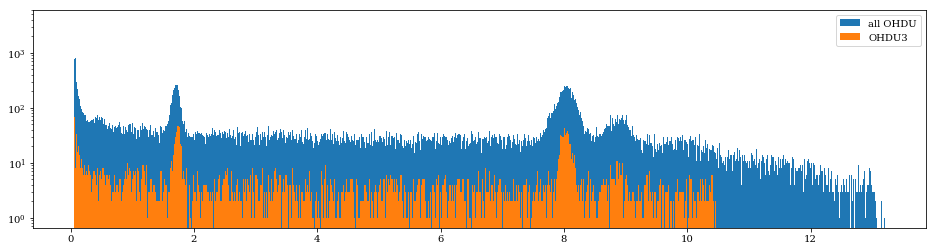

In [77]:
plot_list([ 
    (lambda e: hist(e, arange(e.min(), e.max(), .01), label='all OHDU'))(E0[E0>.05]), 
#     (lambda e: hist(e, arange(e.min(), e.max(), .01)) )(E0[ohdu==2]),
    (lambda e: hist(e, arange(e.min(), e.max(), .01), label="OHDU3") )(E0[(E0>.05)&(ohdu==3)]),
    legend(),
    set_yscale('log') 
])

the distribution of energy versus the depth using both the `sizell` and `xSigmafit`.

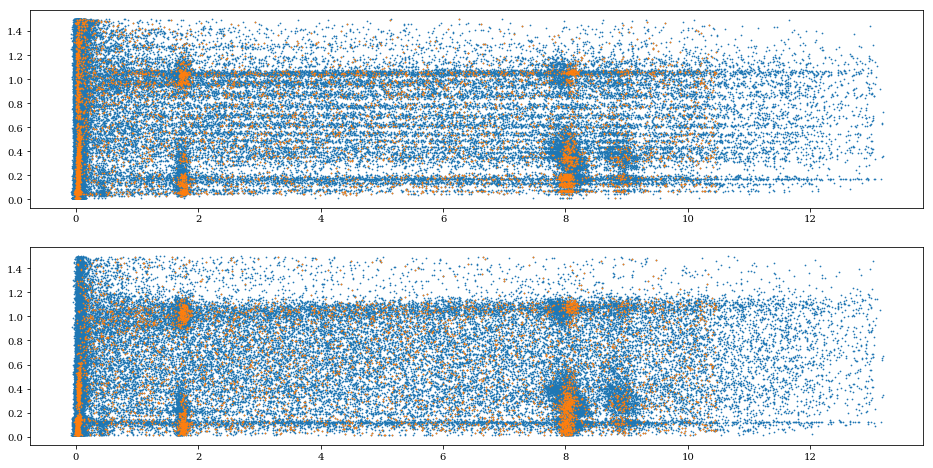

In [78]:
plot_list(
    [ 
        (lambda mask: scatter(E1[mask], sizell[mask], s=.5))( (sizell < 1.5) & (sizell > 0) ) ,
        (lambda mask: scatter(E1[mask], sizell[mask], s=.5))( (sizell < 1.5) & (sizell > 0) & (ohdu==3) ) 
    ],
    [ 
        (lambda mask: scatter(E1[mask], xSigmafit[mask], s=.5))( (xSigmafit < 1.5) & (xSigmafit > 0) ),
        (lambda mask: scatter(E1[mask], xSigmafit[mask], s=.5))( (xSigmafit < 1.5) & (xSigmafit > 0) & (ohdu==3) )
    ]
)

# computation of the efficiency

In order to compute the efficiency we first need to load the simulation catalogs and the compute the spectra of reconstructed events over the simulated events.



The reconstructed events can be selected by imposing the reconstruction distance to be smaller than 1.5 pixels, `distSim<1.5`.

the files for the reconstructed and simulated events are

In [292]:
reconstructed = type('Events', (object,), {})
reconstructed.filenames = sorted(glob('/share/storage2/connie/DAna/nuCatalogs/match_*_sim_[6-7]*_to_*_v4.0.root'))

simulated = type('Events', (object,), {})
simulated.filenames = sorted(glob('/share/storage2/connie/DAna/nuCatalogs/draw_all*.root'))

reconstructed.filenames, simulated.filenames

(['/share/storage2/connie/DAna/nuCatalogs/match_shape_fit_lowE_hpix_ndc_qcalib_catalog_sim_6031_to_6230_v4.0.root',
  '/share/storage2/connie/DAna/nuCatalogs/match_shape_fit_lowE_hpix_ndc_qcalib_catalog_sim_6322_to_6521_v4.0.root',
  '/share/storage2/connie/DAna/nuCatalogs/match_shape_fit_lowE_hpix_ndc_qcalib_catalog_sim_6522_to_6721_v4.0.root',
  '/share/storage2/connie/DAna/nuCatalogs/match_shape_fit_lowE_hpix_ndc_qcalib_catalog_sim_6722_to_6921_v4.0.root',
  '/share/storage2/connie/DAna/nuCatalogs/match_shape_fit_lowE_hpix_ndc_qcalib_catalog_sim_6922_to_7121_v4.0.root',
  '/share/storage2/connie/DAna/nuCatalogs/match_shape_fit_lowE_hpix_ndc_qcalib_catalog_sim_7122_to_7321_v4.0.root',
  '/share/storage2/connie/DAna/nuCatalogs/match_shape_fit_lowE_hpix_ndc_qcalib_catalog_sim_7322_to_7521_v4.0.root'],
 ['/share/storage2/connie/DAna/nuCatalogs/draw_all_events_6031_to_6230_v4.0.root',
  '/share/storage2/connie/DAna/nuCatalogs/draw_all_events_6322_to_6521_v4.0.root',
  '/share/storage2/co

let us do the calculation using the first catalog from `runID` 6031 to 6230.

In [302]:
reconstructed.events = uproot3.open(reconstructed.filenames[0])['hitSumm']
simulated.events = uproot3.open(simulated.filenames[0])['hitSumm']
array(reconstructed.events.keys()), array(simulated.events.keys())

(array([b'runID', b'ohdu', b'expoStart', b'nSat', b'flag', b'xMin',
        b'xMax', b'yMin', b'yMax', b'E0', b'n0', b'xBary0', b'yBary0',
        b'xVar0', b'yVar0', b'E1', b'n1', b'xBary1', b'yBary1', b'xVar1',
        b'yVar1', b'E2', b'n2', b'xBary2', b'yBary2', b'xVar2', b'yVar2',
        b'E3', b'n3', b'xBary3', b'yBary3', b'xVar3', b'yVar3',
        b'nSavedPix', b'xPix', b'yPix', b'level', b'ePix', b'gainCu',
        b'gain3Peaks', b'rawNoise', b'rawDC', b'scnNoise', b'scnDC',
        b'hPixFlag', b'oEntryC', b'xMufit', b'yMufit', b'Efit',
        b'ySigmafit', b'xSigmafit', b'noisell', b'noisellNeg', b'hitll',
        b'sizell', b'muXll', b'muYll', b'chargell', b'skirtll',
        b'minStatusll', b'yLines', b'xLines', b'sigStat', b'chargeStat',
        b'muXStat', b'muYStat', b'entryReco', b'entrySim', b'distSim',
        b'hduSim', b'runIDSim', b'partIDSim', b'rowOffset', b'colOffset',
        b'oEnergy', b'oCharge', b'oMuX', b'oMuY', b'oMuXAfterBin',
        b'oMuYAfterBin',

first we load the simulated energies from both catalogs and correct for their gains

In [358]:
reconstructed.oEnergy = reconstructed.events.array('oEnergy')
reconstructed.oEnergy /= 1e3
reconstructed.ohdu = reconstructed.events.array('ohdu')
reconstructed.distSim = reconstructed.events.array('distSim')
reconstructed.runID = reconstructed.events.array('runID')

simulated.oEnergy = simulated.events.array('oEnergy')
simulated.oEnergy /= 1e3
simulated.ohdu = simulated.events.array('hdu')
simulated.runID = simulated.events.array('runID')

# simulated.runID.min(), simulated.runID.max(), reconstructed.runID.min(), reconstructed.runID.max()
reconstructed.oEnergy.min(), reconstructed.oEnergy.max()

(0.0280126783773303, 2.499999791072681)

now we can compute the efficiency which is the ratio of reconstructed events per simulated events,
$$
\epsilon(E) = \frac{\cal{N}_{\rm R}}{\cal{N}}
$$
where the spectrum of reconstructed events is,
$$
{\cal N}_{\rm R} = \frac{{\rm d} N_{\rm R}}{{\rm d} E_{\rm I}}(E_{\rm I})
$$
and the spectrum of simulated events,
$$
{\cal N} = \frac{{\rm d} N}{{\rm d} E_{\rm I}}(E_{\rm I})
$$

let us calculate the efficiency for `OHDU` 3

parameters
 [ 0.32774984  1.21372038 22.9408105   0.54933069] 
covariance
 [[ 1.57156898e-03  6.08968788e-03  5.29043373e-02 -1.57452379e-03]
 [ 6.08968788e-03  2.54418246e-02  2.33244212e-01 -6.10687573e-03]
 [ 5.29043373e-02  2.33244212e-01  2.26379209e+00 -5.31130784e-02]
 [-1.57452379e-03 -6.10687573e-03 -5.31130784e-02  1.57874552e-03]]
parameters
 [ 0.87694342 49.56393554  0.05752161] 
covariance
 [[ 1.25610289e-06 -1.28818970e-04  1.27687534e-07]
 [-1.28818970e-04  2.47401832e+00  1.61871007e-04]
 [ 1.27687534e-07  1.61871007e-04  4.13757895e-07]]


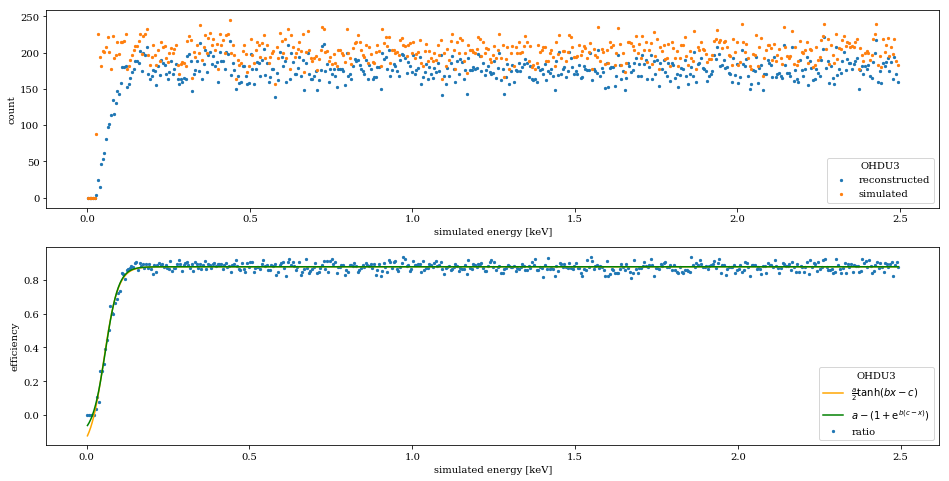

In [401]:
binsize = 5e-3
Emin, Emax= 0, 2.5

mask = simulated.ohdu==3
simulated.hist, bins = histogram( simulated.oEnergy[mask], arange(Emin, Emax, binsize) )

mask = ( reconstructed.ohdu==3 ) & ( reconstructed.distSim<1.5 )
reconstructed.hist, bins = histogram( reconstructed.oEnergy[mask], arange(Emin, Emax, binsize) )

binCenters = .5*(bins[1:]+bins[:-1])

ratio_hist = reconstructed.hist.astype(float)
ratio_hist[ratio_hist>0] /= simulated.hist.astype(float)[ratio_hist>0]

def y_fit(func, x, y, p0, verbose=False):
    popt, pcov = curve_fit( func, x[y>0], y[y>0], p0=p0 )
    if verbose is True:
        print( 'parameters\n', popt, '\ncovariance\n', pcov )
    elif type(verbose) is str:
        print( verbose.format(**locals()) )
    return func(x, *popt)

fitfunc = lambda x, *p: p[0] + p[3]*tanh( p[2]*x-p[1] )
fitfunc2 = lambda x, *p: p[0] - 1/( 1 + exp(-p[1]*(p[2]-x)) )

plot_list(
    [ 
        scatter(binCenters, reconstructed.hist, s=5, label="reconstructed"),
        scatter(binCenters, simulated.hist, s=5, label="simulated"),
        set_ylabel('count'),
        set_xlabel('simulated energy [keV]'),
        legend(title='OHDU3'),
    ],
    [ 
        scatter(binCenters, ratio_hist, s=5, label="ratio"),
        plot(binCenters, y_fit(fitfunc, binCenters, ratio_hist, p0=[1.,1.,1.,1.], verbose=True), 
             c='orange', 
             label=r'$\frac{a}{2}\tanh(b x- c)$' ),
        plot(binCenters, y_fit(fitfunc2, binCenters, ratio_hist, p0=[1.,1.,1.], verbose=True),
             c='green', 
             label=r'$a - (1 + {\rm e}^{b(c-x)})$' ),
        set_ylabel('efficiency'),
        set_xlabel('simulated energy [keV]'),
        legend(title='OHDU3'),
    ]
)

both functions fit very well, so let us zoom in the region of interest

parameters
 [ 0.32236112  1.20142979 22.89056811  0.5549299 ] 
covariance
 [[ 2.13098298e-03  7.70831499e-03  6.48157252e-02 -2.13455005e-03]
 [ 7.70831499e-03  2.98429376e-02  2.64323087e-01 -7.72693565e-03]
 [ 6.48157252e-02  2.64323087e-01  2.47571436e+00 -6.50327965e-02]
 [-2.13455005e-03 -7.72693565e-03 -6.50327965e-02  2.13935415e-03]]
parameters
 [ 0.87716337 49.53292695  0.05748605] 
covariance
 [[ 1.22410634e-06 -1.37749146e-04  1.20832856e-07]
 [-1.37749146e-04  2.57870917e+00  2.07445559e-04]
 [ 1.20832856e-07  2.07445559e-04  4.18319104e-07]]


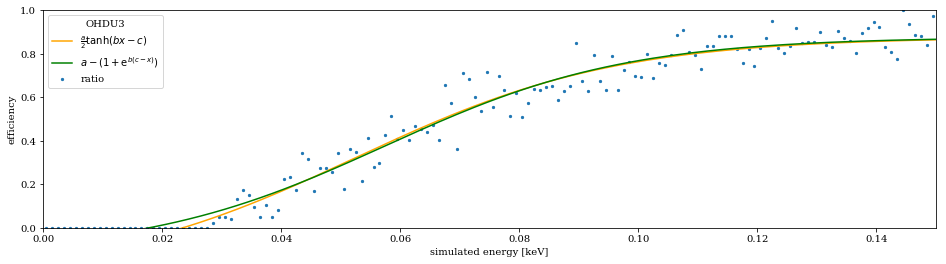

In [404]:
binsize = 1e-3
Emin, Emax= 0, 2.5

mask = simulated.ohdu==3
simulated.hist, bins = histogram( simulated.oEnergy[mask], arange(Emin, Emax, binsize) )

mask = ( reconstructed.ohdu==3 ) & ( reconstructed.distSim<1.5 )
reconstructed.hist, bins = histogram( reconstructed.oEnergy[mask], arange(Emin, Emax, binsize) )

binCenters = .5*(bins[1:]+bins[:-1])

ratio_hist = reconstructed.hist.astype(float)
ratio_hist[ratio_hist>0] /= simulated.hist.astype(float)[ratio_hist>0]

plot_list(
    [ 
        scatter(binCenters, ratio_hist, s=5, label="ratio"),
        plot(binCenters, y_fit(fitfunc, binCenters, ratio_hist, p0=[1.,1.,1.,1.], verbose=True), 
             c='orange', 
             label=r'$\frac{a}{2}\tanh(b x- c)$' ),
        plot(binCenters, y_fit(fitfunc2, binCenters, ratio_hist, p0=[1.,1.,1.], verbose=True), 
             c='green', 
             label=r'$a - (1 + {\rm e}^{b(c-x)})$' ),
        set_ylabel('efficiency'),
        set_xlabel('simulated energy [keV]'),
        set_xlim(.0,.15),
        set_ylim(0,1),
        legend(title='OHDU3'),
    ]
)

the hyperbolic tangent follows the tail closer than the exponent. Now lets find the parameters for the other `OHDU`

OHDU2 [ 0.32287356  1.15004473 22.2562846   0.57626837]
OHDU3 [ 0.32236112  1.20142979 22.89056811  0.5549299 ]
OHDU4 [ 0.35231702  1.2870686  23.64348598  0.54739135]
OHDU5 [ 0.31960542  1.14757081 22.27012347  0.58041063]
OHDU6 [ 0.35504785  1.39087776 25.83264545  0.54478418]
OHDU7 [ 0.3865953   1.3645506  23.52025843  0.51356464]
OHDU8 [ 0.29531045  1.12067758 23.24629414  0.60401372]
OHDU9 [ 0.28704825  1.04979541 21.36972477  0.61373507]
OHDU10 [ 0.38615105  1.49965377 26.30369899  0.51315815]
OHDU11 [ 0.36533638  1.37546214 24.89400588  0.53501916]
OHDU12 [ 0.34042576  1.22977212 23.00236458  0.56103809]
OHDU13 [ 0.37438929  1.42342517 25.06515209  0.52533042]
OHDU14 [ 0.3477176   1.28587064 24.22176138  0.55204091]
OHDU15 [ 0.37699456  1.48805197 26.77335914  0.52116712]


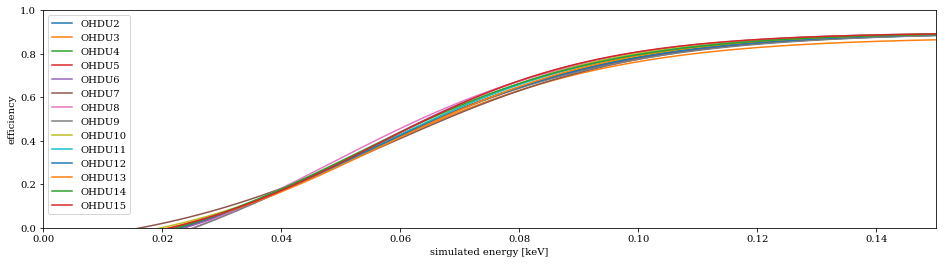

In [408]:
binsize = 1e-3
Emin, Emax= 0, 2.5

def compute_ratio(ohdu):
    mask = simulated.ohdu == ohdu
    simulated.hist, bins = histogram( simulated.oEnergy[mask], arange(Emin, Emax, binsize) )

    mask = ( reconstructed.ohdu==3 ) & ( reconstructed.distSim<1.5 )
    reconstructed.hist, bins = histogram( reconstructed.oEnergy[mask], arange(Emin, Emax, binsize) )

    binCenters = .5*(bins[1:]+bins[:-1])

    ratio_hist = reconstructed.hist.astype(float)
    ratio_hist[ratio_hist>0] /= simulated.hist.astype(float)[ratio_hist>0]
    return ratio_hist

plot_list(
    [ 
        plot(binCenters, y_fit(fitfunc, binCenters, compute_ratio(ohdu), p0=[1.,1.,1.,1.], 
                               verbose=f'OHDU{ohdu} '+'{popt}'), 
             label=f'OHDU{ohdu}' ) 
        for ohdu in range(2,16) ] + [
        set_ylabel('efficiency'),
        set_xlabel('simulated energy [keV]'),
        set_xlim(.0,.15),
        set_ylim(0,1),
        legend(title=''),
    ]
)

now we are ready to compute the fitting function and parameters for all `OHDU` and all catalogs. Let us make a function for that

In [ ]:
def compute_params( matchCatalog, simCatalog, ohdu, binsize=1e-3, Emin=0, Emax=2.5, 
                   func=lambda x, *p: p[0] + p[3]*tanh( p[2]*x-p[1] ) ):
    bins = arange(Emin, Emax, binsize)
    binCenters = .5*(bins[1:]+bins[:-1])
    
    sim = uproot3.open( simCatalog )['hitSumm']
    
    ohdusim = sim.array('hdu')
    Esim = sim.array('oEnergy')[ohdusim == ohdu]/1e3
    histsim, = histogram( Esim, bins )

    rec = uproot3.open( matchCatalog )['hitSumm']
    
    ohdurec = rec.array('ohdu')
    Erec = rec.array('oEnergy')[ohdurec == ohdu]/1e3
    distSim = rec.array('distSim')[ohdurec == ohdu]

    histrec, = histogram( Erec[distSim<1.5], bins )

    ratio_hist = histrec.astype(float)
    ratio_hist[ratio_hist>0] /= histsim.astype(float)[ratio_hist>0]
    
    
    return ratio_hist
    

In [409]:
%%bash
ls *.csv

test.csv
vSpectrum.csv


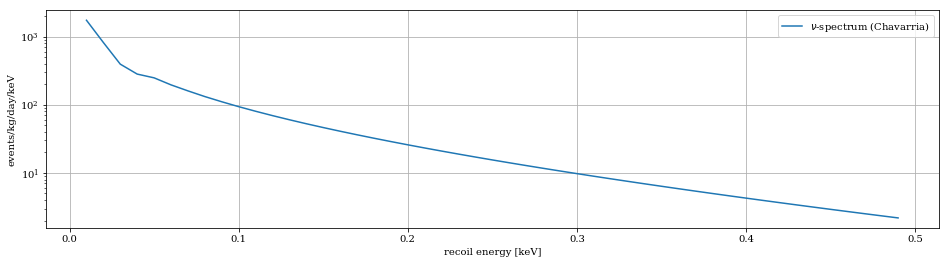

In [432]:
from scipy.interpolate import interp1d
def nu_spectrum(E, file='vSpectrum.csv'):
    '''
        vSpectrum = genfromtxt(file)
        x0, y0 = vSpectrum.T
        y = interp1d(x0,y0)(E)
        return y
    '''
    return interp1d( *genfromtxt(file).T )(E)

E = arange(0.01, .5, .01)
plot_list(
    [ plot(E, nu_spectrum(E), label=r'$\nu$-spectrum (Chavarria)'),
     set_yscale('log'),
     set_xlabel('recoil energy [keV]'),
     set_ylabel('events/kg/day/keV'),
     legend(),
     grid()
    ]
)

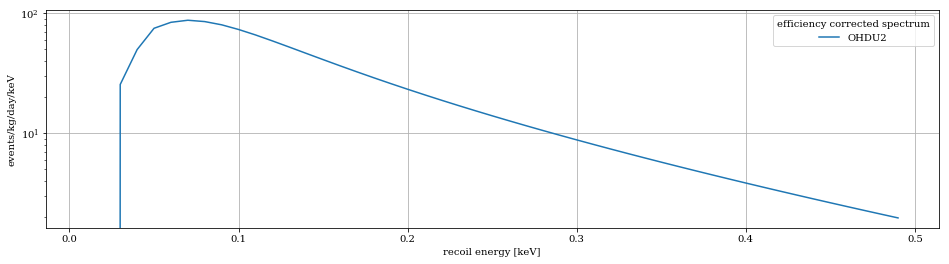

In [436]:
p = [ 0.32287356, 1.15004473, 22.2562846, 0.57626837]

E = arange(0.01, .5, .01)
plot_list(
    [ plot( E, nu_spectrum(E)*fitfunc(E, *p), label='OHDU2' ), 
     set_yscale('log'),
     set_xlabel('recoil energy [keV]'),
     set_ylabel('events/kg/day/keV'),
     legend(title='efficiency corrected spectrum'),
     grid()
    ]
)

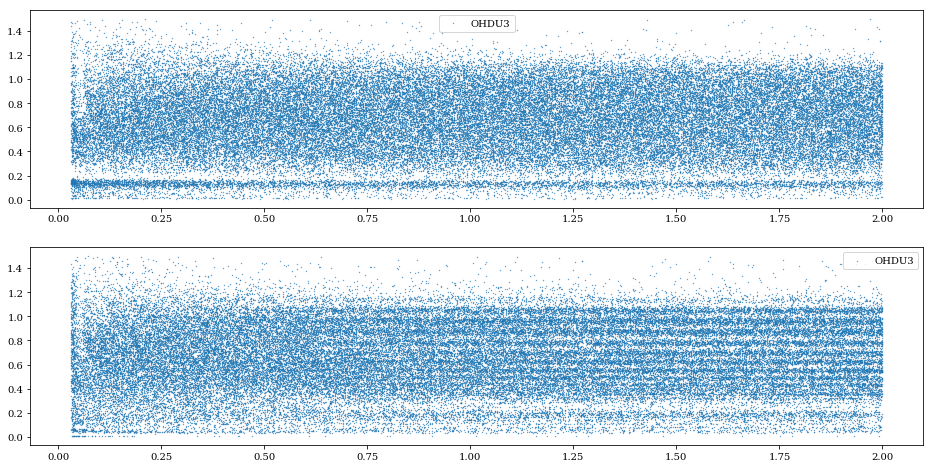

In [29]:
mask_sigma = (E0>.0)&(E0<2)&(xSigmafit<1.5)&(xSigmafit>0)&(ohdu==3)&(distSim<2)
mask_size = (E0>.0)&(E0<2)&(sizell<1.5)&(sizell>0)&(ohdu==3)&(distSim<2)
plot_list(
    [
    (lambda e, sigma: scatter( e, sigma, s=.1, label="OHDU3") )( E0[mask_sigma], xSigmafit[mask_sigma] ),
    legend(),
    ],
    [
    (lambda e, sigma: scatter( e, sigma, s=.1, label="OHDU3") )( E0[mask_size], sizell[mask_size] ),
    legend(),
    ],    
)

In [122]:
%%bash
more /share/storage2/connie/DAna/Macros/NuSims/simulationConfig_binnig_5.xml

::::::::::::::
/share/storage2/connie/DAna/Macros/NuSims/simulationConfig_binnig_5.xml
::::::::::::::
<!-- [noise]=e--->
<noise
default="0"
/>
<!-- [darkCurrent]=e-/adu/pixel, before binning-->
<darkCurrent
default="0"

/>
<!-- [gain]=e-/adu-->
<gain
default="1e6"

ext2="0.173806"
ext3="0.139682"
ext4="0.162393"
ext5="0.155248"
ext6="0.16284"
ext7="0.182676"
ext8="0.141687"
ext9="0.136321"
ext10="0.149495"
ext11="0.15"
ext12="0.15"
ext13="0.122618"
ext14="0.137117"
ext15="0.122639"
/>

<ccdConfig
pixelSize="15"
thickness="675"
elecIonizEner = "3.745"
/>

<!-- if new image: cols and rows here are final size of the image after binning
Nevents are events per hdu -->
<simulationConfig
Nevents="500"
randomSeed="0"
numBinningCols="1"
numBinningRows="5"
colsNewImage="8540"
rowsNewImage="900"
/>

<!-- events coordinates are before binning-->
<pointEvent
EPDF = "1"
EMin = "28"
EMax = "2500"

zPDF = "1"
zMin = "0.01"
zMax = "675"

xPDF = "1"
xMin = "9"
xMax = "4121"

yPDF = "1"
yMin = "1"
yMax =

In [255]:
%%bash
ls -d /share/storage2/connie/DAna/nuCatalogs/match*

/share/storage2/connie/DAna/nuCatalogs/match_shape_fit_lowE_hpix_ndc_qcalib_catalog_sim_14713_to_14912_v4.0.root
/share/storage2/connie/DAna/nuCatalogs/match_shape_fit_lowE_hpix_ndc_qcalib_catalog_sim_14913_to_15177_v4.0.root
/share/storage2/connie/DAna/nuCatalogs/match_shape_fit_lowE_hpix_ndc_qcalib_catalog_sim_6031_to_6230_v4.0.root
/share/storage2/connie/DAna/nuCatalogs/match_shape_fit_lowE_hpix_ndc_qcalib_catalog_sim_6322_to_6521_v4.0.root
/share/storage2/connie/DAna/nuCatalogs/match_shape_fit_lowE_hpix_ndc_qcalib_catalog_sim_6522_to_6721_v4.0.root
/share/storage2/connie/DAna/nuCatalogs/match_shape_fit_lowE_hpix_ndc_qcalib_catalog_sim_6722_to_6921_v4.0.root
/share/storage2/connie/DAna/nuCatalogs/match_shape_fit_lowE_hpix_ndc_qcalib_catalog_sim_6922_to_7121_v4.0.root
/share/storage2/connie/DAna/nuCatalogs/match_shape_fit_lowE_hpix_ndc_qcalib_catalog_sim_7122_to_7321_v4.0.root
/share/storage2/connie/DAna/nuCatalogs/match_shape_fit_lowE_hpix_ndc_qcalib_catalog_sim_7322_to_7521_v4.0.ro

In [265]:
%%bash
ls /share/storage2/connie/DAna/nuCatalogs/draw_all_*.root

/share/storage2/connie/DAna/nuCatalogs/draw_all_events_6031_to_6230_v4.0.root
/share/storage2/connie/DAna/nuCatalogs/draw_all_events_6322_to_6521_v4.0.root
/share/storage2/connie/DAna/nuCatalogs/draw_all_events_6522_to_6721_v4.0.root
/share/storage2/connie/DAna/nuCatalogs/draw_all_events_6722_to_6921_v4.0.root
/share/storage2/connie/DAna/nuCatalogs/draw_all_events_6922_to_7121_v4.0.root
/share/storage2/connie/DAna/nuCatalogs/draw_all_events_7122_to_7321_v4.0.root
/share/storage2/connie/DAna/nuCatalogs/draw_all_events_7322_to_7521_v4.0.root


In [266]:
a = uproot3.open(glob('/share/storage2/connie/DAna/nuCatalogs/draw_all_events_6722_to_*_v4.0.root')[0])['hitSumm']
a.array(['runID'])

array([6722, 6722, 6722, ..., 6921, 6921, 6921], dtype=int32)

In [ ]:
Ucapture = [
    [0.044, 0.019],
    [0.112, 0.03],
    [0.135, 0.014],
    [0.147, 0.043],
    [0.182, 0.057],
    [0.206, 0.102],
    [0.294, 0.111],
    [0.341, 0.091],
    [0.388, 0.086],
    [0.435, 0.05],
    [0.488, 0.024],
    [0.5, 0.012],
    [0.541, 0.016],
    [0.612, 0.017],
    [0.706, 0.011],
    [0.771, 0.012],
    [0.835, 0.01],
    [0.847, 0.012],
    [0.894, 0.011],
    [0.912, 0.013],
    [0.924, 0.014],
    [0.976, 0.014],
    [1, 0.018],
    [1.088, 0.017],
    [1.165, 0.007],
    [1.188, 0.003],
    [1.262, 0],
]

E_x, N_x = list( zip( *capture ) )
array(E_x), array(N_x)
with Figure() as fig:
    with fig.addAxes(yscale='log') as ax:
        ax.plot( *list( zip( *capture ) ) )